# Need to do:
1. Monte Carlo 
2. Plots/Visualizations
3. Proof read/change comments throughout document
4. run notebook through to only show visualizations
5. Readme (use section titles as guides)
6. Presentation Slides
7. png images? (ask tutor)

# Part I: Imports

In [125]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

%matplotlib inline

# Part II: API Data Extraction & Cleansing

In [2]:
path = ('/Users/jordanromnes/Downloads/Project_1/keys.env')

In [3]:
# Load .env environment variables
load_dotenv(path)

True

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [5]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [6]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

### **** Switch timestamp/corresponding comments ****

In [7]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2021-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2024-01-01', tz='America/New_York').isoformat()

In [8]:
# Get 5 years' worth of historical data for Snowflake Inc SNOW
timeframe = "1Day"
ticker = ['AAPL', 'JPM', 'META', 'UNP', 'XOM', 'NEE', 'UNH', 'RIO', 'EQIX', 'WMT', 'AMZN']
portfolio_df = alpaca.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=10000
).df

# Reorganize the DataFrame
# Separate ticker data
AAPL = portfolio_df[portfolio_df['symbol']=='AAPL'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
JPM = portfolio_df[portfolio_df['symbol']=='JPM'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
META = portfolio_df[portfolio_df['symbol']=='META'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
UNP = portfolio_df[portfolio_df['symbol']=='UNP'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
XOM = portfolio_df[portfolio_df['symbol']=='XOM'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
NEE = portfolio_df[portfolio_df['symbol']=='NEE'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
UNH = portfolio_df[portfolio_df['symbol']=='UNH'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
RIO = portfolio_df[portfolio_df['symbol']=='RIO'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
EQIX = portfolio_df[portfolio_df['symbol']=='EQIX'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
WMT = portfolio_df[portfolio_df['symbol']=='WMT'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
AMZN = portfolio_df[portfolio_df['symbol']=='AMZN'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)

# Concatenate the ticker DataFrames
portfolio_df = pd.concat([AAPL, JPM, META, UNP, XOM, NEE, UNH, RIO, EQIX, WMT, AMZN],axis=1, keys=['AAPL', 'JPM', 'META', 'UNP', 'XOM', 'NEE', 'UNH', 'RIO', 'EQIX', 'WMT', 'AMZN'])


# Display sample data
portfolio_df.head()

AAPL     JPM    META     UNP    XOM    NEE  \
                            close   close   close   close  close  close   
timestamp                                                                 
2021-01-04 05:00:00+00:00  129.41  125.87  268.94  203.01  41.50  74.22   
2021-01-05 05:00:00+00:00  131.01  125.65  270.97  205.50  43.50  74.77   
2021-01-06 05:00:00+00:00  126.66  131.55  263.34  209.80  44.61  78.43   
2021-01-07 05:00:00+00:00  130.92  135.87  268.74  212.72  44.96  79.29   
2021-01-08 05:00:00+00:00  132.05  136.02  267.57  218.82  45.46  81.13   

                              UNH    RIO    EQIX     WMT     AMZN  
                            close  close   close   close    close  
timestamp                                                          
2021-01-04 05:00:00+00:00  349.50  77.39  692.56  146.53  3186.63  
2021-01-05 05:00:00+00:00  344.80  79.26  691.54  145.75  3218.51  
2021-01-06 05:00:00+00:00  359.27  82.80  668.96  146.66  3138.38  
2021-01-07 05:00:00+00:00  365.03  85.98  678.97  146.65  3162.16  
2021-01-08 05:00:00+00:00  363.39  86.69  692.46  146.63  3182.70

# Part III: Historical Analysis
Contains:

• Daily returns of all stocks composing portfolio. Each stock is representing a sector for the purpose of our experiment/analysis.

• Daily and cumulative returns of each weighted portfolio. Our control portfolio has all 11 stocks weighted evenly(0.09 each). We have 11 other portfolios with 10 stocks weighted evenly (0.075), while one stock is weighted (0.25). Each of the 11 non control portfolios has a different stock weighted more heavily to show the performance of each sector. 

• Historical values of each weighted portfolio. With a given investment of $20,000 at the start date of our historical data. We calculated the historical value of that initial investment today to compare how each "sector/portfolio" performed.

## All Stocks Daily Returns
*Need Line plot*

In [9]:
# Calculate daily returns
stock_returns = portfolio_df.pct_change()
# Drop NAs
stock_returns = portfolio_df.pct_change().dropna()
# Display sample data
stock_returns.head()

AAPL       JPM      META       UNP       XOM  \
                              close     close     close     close     close   
timestamp                                                                     
2021-01-05 05:00:00+00:00  0.012364 -0.001748  0.007548  0.012265  0.048193   
2021-01-06 05:00:00+00:00 -0.033204  0.046956 -0.028158  0.020925  0.025517   
2021-01-07 05:00:00+00:00  0.033633  0.032839  0.020506  0.013918  0.007846   
2021-01-08 05:00:00+00:00  0.008631  0.001104 -0.004354  0.028676  0.011121   
2021-01-11 05:00:00+00:00 -0.023249  0.014924 -0.040102 -0.006718  0.030356   

                                NEE       UNH       RIO      EQIX       WMT  \
                              close     close     close     close     close   
timestamp                                                                     
2021-01-05 05:00:00+00:00  0.007410 -0.013448  0.024163 -0.001473 -0.005323   
2021-01-06 05:00:00+00:00  0.048950  0.041966  0.044663 -0.032652  0.006244   
2021-01-07 05:00:00+00:00  0.010965  0.016033  0.038406  0.014964 -0.000068   
2021-01-08 05:00:00+00:00  0.023206 -0.004493  0.008258  0.019868 -0.000136   
2021-01-11 05:00:00+00:00 -0.017749 -0.007265 -0.033568 -0.014542  0.004501   

                               AMZN  
                              close  
timestamp                            
2021-01-05 05:00:00+00:00  0.010004  
2021-01-06 05:00:00+00:00 -0.024897  
2021-01-07 05:00:00+00:00  0.007577  
2021-01-08 05:00:00+00:00  0.006496  
2021-01-11 05:00:00+00:00 -0.021519

In [10]:
# Set weights
weights = [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]

# Calculate portfolio return
control_historical = stock_returns.dot(weights)
# Display sample data
control_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.008996
2021-01-06 05:00:00+00:00    0.010468
2021-01-07 05:00:00+00:00    0.017696
2021-01-08 05:00:00+00:00    0.008854
2021-01-11 05:00:00+00:00   -0.010344
dtype: float64

## Daily returns, Cumulative returns, historical value of evenly weighted portfolio ("Control")

In [11]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
control_cumulative_returns = (1 + pd.Series(control_historical)).cumprod()

# Calculating historical value
control_historical_value = initial_investment * control_cumulative_returns


control_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    24720.635167
2023-12-26 05:00:00+00:00    24792.511978
2023-12-27 05:00:00+00:00    24890.990275
2023-12-28 05:00:00+00:00    24915.120241
2023-12-29 05:00:00+00:00    24814.826872
dtype: float64

## Daily returns, Cumulative returns, historical value of tech heavy portfolio ("Technology")

In [12]:
# Set weights
weights = [0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
tech_historical = stock_returns.dot(weights)
# Display sample data
tech_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.009660
2021-01-06 05:00:00+00:00    0.002913
2021-01-07 05:00:00+00:00    0.020632
2021-01-08 05:00:00+00:00    0.008889
2021-01-11 05:00:00+00:00   -0.012688
dtype: float64

In [13]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
tech_cumulative_returns = (1 + pd.Series(tech_historical)).cumprod()

# Calculating historical value
tech_historical_value = initial_investment * tech_cumulative_returns


tech_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    25803.575097
2023-12-26 05:00:00+00:00    25853.267888
2023-12-27 05:00:00+00:00    25941.187925
2023-12-28 05:00:00+00:00    25972.251158
2023-12-29 05:00:00+00:00    25860.473824
dtype: float64

## Daily returns, Cumulative returns, historical value of financial heavy portfolio ("Financial")

In [14]:
# Set weights
weights = [0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
fin_historical = stock_returns.dot(weights)
# Display sample data
fin_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.007191
2021-01-06 05:00:00+00:00    0.016941
2021-01-07 05:00:00+00:00    0.020493
2021-01-08 05:00:00+00:00    0.007571
2021-01-11 05:00:00+00:00   -0.006008
dtype: float64

In [15]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
fin_cumulative_returns = (1 + pd.Series(fin_historical)).cumprod()

# Calculating historical value
fin_historical_value = initial_investment * fin_cumulative_returns


fin_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    25283.809939
2023-12-26 05:00:00+00:00    25371.239220
2023-12-27 05:00:00+00:00    25481.850939
2023-12-28 05:00:00+00:00    25526.128377
2023-12-29 05:00:00+00:00    25435.254820
dtype: float64

## Daily returns, Cumulative returns, historical value of consumer services heavy portfolio ("Consumer Services")

In [16]:
# Set weights
weights = [0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
con_ser_historical = stock_returns.dot(weights)
# Display sample data
con_ser_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.008818
2021-01-06 05:00:00+00:00    0.003796
2021-01-07 05:00:00+00:00    0.018335
2021-01-08 05:00:00+00:00    0.006616
2021-01-11 05:00:00+00:00   -0.015638
dtype: float64

In [17]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
con_ser_cumulative_returns = (1 + pd.Series(con_ser_historical)).cumprod()

# Calculating historical value
con_ser_historical_value = initial_investment * con_ser_cumulative_returns


con_ser_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    25858.853376
2023-12-26 05:00:00+00:00    25939.948358
2023-12-27 05:00:00+00:00    26064.191989
2023-12-28 05:00:00+00:00    26091.494066
2023-12-29 05:00:00+00:00    25948.411364
dtype: float64

## Daily returns, Cumulative returns, historical value of industrial heavy portfolio ("Industrial")

In [18]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
ind_historical = stock_returns.dot(weights)
# Display sample data
ind_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.009643
2021-01-06 05:00:00+00:00    0.012385
2021-01-07 05:00:00+00:00    0.017182
2021-01-08 05:00:00+00:00    0.012397
2021-01-11 05:00:00+00:00   -0.009795
dtype: float64

In [19]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
ind_cumulative_returns = (1 + pd.Series(ind_historical)).cumprod()

# Calculating historical value
ind_historical_value = initial_investment * ind_cumulative_returns


ind_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    24828.950085
2023-12-26 05:00:00+00:00    24919.613457
2023-12-27 05:00:00+00:00    25011.344334
2023-12-28 05:00:00+00:00    25035.289207
2023-12-29 05:00:00+00:00    24944.185008
dtype: float64

## Daily returns, Cumulative returns, historical value of energy heavy portfolio ("Energy")

In [20]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
nrg_historical = stock_returns.dot(weights)
# Display sample data
nrg_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.015930
2021-01-06 05:00:00+00:00    0.013189
2021-01-07 05:00:00+00:00    0.016119
2021-01-08 05:00:00+00:00    0.009324
2021-01-11 05:00:00+00:00   -0.003307
dtype: float64

In [21]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
nrg_cumulative_returns = (1 + pd.Series(nrg_historical)).cumprod()

# Calculating historical value
nrg_historical_value = initial_investment * nrg_cumulative_returns


nrg_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    28387.863187
2023-12-26 05:00:00+00:00    28467.858077
2023-12-27 05:00:00+00:00    28538.677037
2023-12-28 05:00:00+00:00    28489.515198
2023-12-29 05:00:00+00:00    28383.497035
dtype: float64

## Daily returns, Cumulative returns, historical value of utilities heavy portfolio ("Utilities")

In [22]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
util_historical = stock_returns.dot(weights)
# Display sample data
util_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.008794
2021-01-06 05:00:00+00:00    0.017290
2021-01-07 05:00:00+00:00    0.016665
2021-01-08 05:00:00+00:00    0.011439
2021-01-11 05:00:00+00:00   -0.011726
dtype: float64

In [23]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
util_cumulative_returns = (1 + pd.Series(util_historical)).cumprod()

# Calculating historical value
util_historical_value = initial_investment * util_cumulative_returns


util_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    23242.753779
2023-12-26 05:00:00+00:00    23330.384765
2023-12-27 05:00:00+00:00    23432.699812
2023-12-28 05:00:00+00:00    23481.414083
2023-12-29 05:00:00+00:00    23383.789707
dtype: float64

## Daily returns, Cumulative returns, historical value of healthcare heavy portfolio ("Healthcare")

In [24]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075]
# Calculate portfolio return
hc_historical = stock_returns.dot(weights)
# Display sample data
hc_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.005143
2021-01-06 05:00:00+00:00    0.016067
2021-01-07 05:00:00+00:00    0.017552
2021-01-08 05:00:00+00:00    0.006592
2021-01-11 05:00:00+00:00   -0.009891
dtype: float64

In [25]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
hc_cumulative_returns = (1 + pd.Series(hc_historical)).cumprod()

# Calculating historical value
hc_historical_value = initial_investment * hc_cumulative_returns


hc_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    25827.296313
2023-12-26 05:00:00+00:00    25887.442786
2023-12-27 05:00:00+00:00    25997.176409
2023-12-28 05:00:00+00:00    26036.540328
2023-12-29 05:00:00+00:00    25962.829100
dtype: float64

## Daily returns, Cumulative returns, historical value of materials heavy portfolio ("Materials")

In [26]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075]
# Calculate portfolio return
mat_historical = stock_returns.dot(weights)
# Display sample data
mat_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.011725
2021-01-06 05:00:00+00:00    0.016539
2021-01-07 05:00:00+00:00    0.021467
2021-01-08 05:00:00+00:00    0.008823
2021-01-11 05:00:00+00:00   -0.014494
dtype: float64

In [27]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
mat_cumulative_returns = (1 + pd.Series(mat_historical)).cumprod()

# Calculating historical value
mat_historical_value = initial_investment * mat_cumulative_returns


mat_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    24070.449697
2023-12-26 05:00:00+00:00    24148.740711
2023-12-27 05:00:00+00:00    24262.287284
2023-12-28 05:00:00+00:00    24268.826874
2023-12-29 05:00:00+00:00    24182.858921
dtype: float64

## Daily returns, Cumulative returns, historical value of real estate heavy portfolio ("Real Estate")

In [28]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075]
# Calculate portfolio return
re_historical = stock_returns.dot(weights)
# Display sample data
re_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.007239
2021-01-06 05:00:00+00:00    0.003009
2021-01-07 05:00:00+00:00    0.017365
2021-01-08 05:00:00+00:00    0.010855
2021-01-11 05:00:00+00:00   -0.011165
dtype: float64

In [29]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
re_cumulative_returns = (1 + pd.Series(re_historical)).cumprod()

# Calculating historical value
re_historical_value = initial_investment * re_cumulative_returns


re_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    24758.580557
2023-12-26 05:00:00+00:00    24842.734596
2023-12-27 05:00:00+00:00    24939.725475
2023-12-28 05:00:00+00:00    24998.926956
2023-12-29 05:00:00+00:00    24868.315367
dtype: float64

## Daily returns, Cumulative returns, historical value of consumer staples heavy portfolio ("Consumer Staples")

In [30]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075]
# Calculate portfolio return
con_staple_historical = stock_returns.dot(weights)
# Display sample data
con_staple_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.006565
2021-01-06 05:00:00+00:00    0.009816
2021-01-07 05:00:00+00:00    0.014734
2021-01-08 05:00:00+00:00    0.007354
2021-01-11 05:00:00+00:00   -0.007832
dtype: float64

In [31]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
con_staple_cumulative_returns = (1 + pd.Series(con_staple_historical)).cumprod()

# Calculating historical value
con_staple_historical_value = initial_investment * con_staple_cumulative_returns


con_staple_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    24354.611269
2023-12-26 05:00:00+00:00    24407.091943
2023-12-27 05:00:00+00:00    24528.024149
2023-12-28 05:00:00+00:00    24539.411023
2023-12-29 05:00:00+00:00    24459.273844
dtype: float64

## Daily returns, Cumulative returns, historical value of consumer discretionary heavy portfolio ("Consumer Discretionary")

In [32]:
# Set weights
weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25]
# Calculate portfolio return
con_disc_historical = stock_returns.dot(weights)
# Display sample data
con_disc_historical.head()

timestamp
2021-01-05 05:00:00+00:00    0.009247
2021-01-06 05:00:00+00:00    0.004366
2021-01-07 05:00:00+00:00    0.016072
2021-01-08 05:00:00+00:00    0.008515
2021-01-11 05:00:00+00:00   -0.012386
dtype: float64

In [33]:
# Initial investment
initial_investment = 20000

# Calculating cumulative returns
con_disc_cumulative_returns = (1 + pd.Series(con_disc_historical)).cumprod()

# Calculating historical value
con_disc_historical_value = initial_investment * con_disc_cumulative_returns


con_disc_historical_value.tail()

timestamp
2023-12-22 05:00:00+00:00    19753.190907
2023-12-26 05:00:00+00:00    19800.826967
2023-12-27 05:00:00+00:00    19864.788204
2023-12-28 05:00:00+00:00    19881.742900
2023-12-29 05:00:00+00:00    19782.384293
dtype: float64

## Concatenating portfolio returns for plotting

### Combining/concatenating all historical values(cumulative returns * initial investment) of all portfolios with an initial investment of $20,000 from 1/05/2021 through 12/29/2023
*Need Line plot*

In [34]:
all_historical_values_df = pd.concat([
    control_historical_value, 
    tech_historical_value,
    fin_historical_value,
    con_ser_historical_value,
    ind_historical_value,
    nrg_historical_value,
    util_historical_value,
    hc_historical_value,
    mat_historical_value,
    re_historical_value,
    con_staple_historical_value,
    con_disc_historical_value], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

all_historical_values_df

Control    Technology       Finance  \
timestamp                                                             
2021-01-05 05:00:00+00:00  20179.921892  20193.208228  20143.817487   
2021-01-06 05:00:00+00:00  20391.164696  20252.024635  20485.065399   
2021-01-07 05:00:00+00:00  20751.999316  20669.868439  20904.870500   
2021-01-08 05:00:00+00:00  20935.736398  20853.597789  21063.151471   
2021-01-11 05:00:00+00:00  20719.182599  20589.000722  20936.603331   
...                                 ...           ...           ...   
2023-12-22 05:00:00+00:00  24720.635167  25803.575097  25283.809939   
2023-12-26 05:00:00+00:00  24792.511978  25853.267888  25371.239220   
2023-12-27 05:00:00+00:00  24890.990275  25941.187925  25481.850939   
2023-12-28 05:00:00+00:00  24915.120241  25972.251158  25526.128377   
2023-12-29 05:00:00+00:00  24814.826872  25860.473824  25435.254820   

                           Consumer Services    Industrial        Energy  \
timestamp                                                                  
2021-01-05 05:00:00+00:00       20176.353442  20192.863830  20318.609609   
2021-01-06 05:00:00+00:00       20252.935627  20442.954635  20586.588196   
2021-01-07 05:00:00+00:00       20624.270766  20794.205808  20918.431101   
2021-01-08 05:00:00+00:00       20760.729182  21051.983724  21113.484232   
2021-01-11 05:00:00+00:00       20436.081774  20845.770985  21043.653067   
...                                      ...           ...           ...   
2023-12-22 05:00:00+00:00       25858.853376  24828.950085  28387.863187   
2023-12-26 05:00:00+00:00       25939.948358  24919.613457  28467.858077   
2023-12-27 05:00:00+00:00       26064.191989  25011.344334  28538.677037   
2023-12-28 05:00:00+00:00       26091.494066  25035.289207  28489.515198   
2023-12-29 05:00:00+00:00       25948.411364  24944.185008  28383.497035   

                              Utilities    Healthcare     Materials  \
timestamp                                                             
2021-01-05 05:00:00+00:00  20175.871315  20102.867671  20234.506560   
2021-01-06 05:00:00+00:00  20524.703610  20425.868896  20569.172273   
2021-01-07 05:00:00+00:00  20866.753369  20784.384815  21010.738458   
2021-01-08 05:00:00+00:00  21105.455050  20921.396553  21196.124437   
2021-01-11 05:00:00+00:00  20857.974410  20714.460005  20888.904361   
...                                 ...           ...           ...   
2023-12-22 05:00:00+00:00  23242.753779  25827.296313  24070.449697   
2023-12-26 05:00:00+00:00  23330.384765  25887.442786  24148.740711   
2023-12-27 05:00:00+00:00  23432.699812  25997.176409  24262.287284   
2023-12-28 05:00:00+00:00  23481.414083  26036.540328  24268.826874   
2023-12-29 05:00:00+00:00  23383.789707  25962.829100  24182.858921   

                            Real Estate  Consumer Staples  \
timestamp                                                   
2021-01-05 05:00:00+00:00  20144.780122      20131.303913   
2021-01-06 05:00:00+00:00  20205.400788      20328.911427   
2021-01-07 05:00:00+00:00  20556.267167      20628.446361   
2021-01-08 05:00:00+00:00  20779.410507      20780.156662   
2021-01-11 05:00:00+00:00  20547.414724      20617.404691   
...                                 ...               ...   
2023-12-22 05:00:00+00:00  24758.580557      24354.611269   
2023-12-26 05:00:00+00:00  24842.734596      24407.091943   
2023-12-27 05:00:00+00:00  24939.725475      24528.024149   
2023-12-28 05:00:00+00:00  24998.926956      24539.411023   
2023-12-29 05:00:00+00:00  24868.315367      24459.273844   

                           Consumer Discretionary  
timestamp                                          
2021-01-05 05:00:00+00:00            20184.949957  
2021-01-06 05:00:00+00:00            20273.085531  
2021-01-07 05:00:00+00:00            20598.921973  
2021-01-08 05:00:00+00:00            20774.322028  
2021-01-11 05:00:00+00:00            20517.017735  
...                                  

### Combining/concatenating all cumulative returns of all portfolios from 1/05/2021 through 12/29/2023

*Need Line plot*

In [35]:
all_cumulative_returns_df = pd.concat([
    control_cumulative_returns, 
    tech_cumulative_returns,
    fin_cumulative_returns,
    con_ser_cumulative_returns,
    ind_cumulative_returns,
    nrg_cumulative_returns,
    util_cumulative_returns,
    hc_cumulative_returns,
    mat_cumulative_returns,
    re_cumulative_returns,
    con_staple_cumulative_returns,
    con_disc_cumulative_returns], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

all_cumulative_returns_df

Control  Technology   Finance  Consumer Services  \
timestamp                                                                      
2021-01-05 05:00:00+00:00  1.008996    1.009660  1.007191           1.008818   
2021-01-06 05:00:00+00:00  1.019558    1.012601  1.024253           1.012647   
2021-01-07 05:00:00+00:00  1.037600    1.033493  1.045244           1.031214   
2021-01-08 05:00:00+00:00  1.046787    1.042680  1.053158           1.038036   
2021-01-11 05:00:00+00:00  1.035959    1.029450  1.046830           1.021804   
...                             ...         ...       ...                ...   
2023-12-22 05:00:00+00:00  1.236032    1.290179  1.264190           1.292943   
2023-12-26 05:00:00+00:00  1.239626    1.292663  1.268562           1.296997   
2023-12-27 05:00:00+00:00  1.244550    1.297059  1.274093           1.303210   
2023-12-28 05:00:00+00:00  1.245756    1.298613  1.276306           1.304575   
2023-12-29 05:00:00+00:00  1.240741    1.293024  1.271763           1.297421   

                           Industrial    Energy  Utilities  Healthcare  \
timestamp                                                                
2021-01-05 05:00:00+00:00    1.009643  1.015930   1.008794    1.005143   
2021-01-06 05:00:00+00:00    1.022148  1.029329   1.026235    1.021293   
2021-01-07 05:00:00+00:00    1.039710  1.045922   1.043338    1.039219   
2021-01-08 05:00:00+00:00    1.052599  1.055674   1.055273    1.046070   
2021-01-11 05:00:00+00:00    1.042289  1.052183   1.042899    1.035723   
...                               ...       ...        ...         ...   
2023-12-22 05:00:00+00:00    1.241448  1.419393   1.162138    1.291365   
2023-12-26 05:00:00+00:00    1.245981  1.423393   1.166519    1.294372   
2023-12-27 05:00:00+00:00    1.250567  1.426934   1.171635    1.299859   
2023-12-28 05:00:00+00:00    1.251764  1.424476   1.174071    1.301827   
2023-12-29 05:00:00+00:00    1.247209  1.419175   1.169189    1.298141   

                           Materials  Real Estate  Consumer Staples  \
timestamp                                                             
2021-01-05 05:00:00+00:00   1.011725     1.007239          1.006565   
2021-01-06 05:00:00+00:00   1.028459     1.010270          1.016446   
2021-01-07 05:00:00+00:00   1.050537     1.027813          1.031422   
2021-01-08 05:00:00+00:00   1.059806     1.038971          1.039008   
2021-01-11 05:00:00+00:00   1.044445     1.027371          1.030870   
...                              ...          ...               ...   
2023-12-22 05:00:00+00:00   1.203522     1.237929          1.217731   
2023-12-26 05:00:00+00:00   1.207437     1.242137          1.220355   
2023-12-27 05:00:00+00:00   1.213114     1.246986          1.226401   
2023-12-28 05:00:00+00:00   1.213441     1.249946          1.226971   
2023-12-29 05:00:00+00:00   1.209143     1.243416          1.222964   

                           Consumer Discretionary  
timestamp                                          
2021-01-05 05:00:00+00:00                1.009247  
2021-01-06 05:00:00+00:00                1.013654  
2021-01-07 05:00:00+00:00                1.029946  
2021-01-08 05:00:00+00:00                1.038716  
2021-01-11 05:00:00+00:00                1.025851  
...                                           ...  
2023-12-22 05:00:00+00:00                0.987660  
2023-12-26 05:00:00+00:00                0.990041  
2023-12-27 05:00:00+00:00                0.993239  
2023-12-28 05:00:00+00:00                0.994087  
2023-12-29 05:00:00+00:00                0.989119  

[752 rows x 12 columns]

### Combining/concatenating all daily returns of all portfolios from 1/05/2021 through 12/29/2023

*Need Line plot*

In [36]:
all_returns_df = pd.concat([
    control_historical, 
    tech_historical,
    fin_historical,
    con_ser_historical,
    ind_historical,
    nrg_historical,
    util_historical,
    hc_historical,
    mat_historical,
    re_historical,
    con_staple_historical,
    con_disc_historical], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

all_returns_df

Control  Technology   Finance  Consumer Services  \
timestamp                                                                      
2021-01-05 05:00:00+00:00  0.008996    0.009660  0.007191           0.008818   
2021-01-06 05:00:00+00:00  0.010468    0.002913  0.016941           0.003796   
2021-01-07 05:00:00+00:00  0.017696    0.020632  0.020493           0.018335   
2021-01-08 05:00:00+00:00  0.008854    0.008889  0.007571           0.006616   
2021-01-11 05:00:00+00:00 -0.010344   -0.012688 -0.006008          -0.015638   
...                             ...         ...       ...                ...   
2023-12-22 05:00:00+00:00  0.000683   -0.000401  0.000465           0.000223   
2023-12-26 05:00:00+00:00  0.002908    0.001926  0.003458           0.003136   
2023-12-27 05:00:00+00:00  0.003972    0.003401  0.004360           0.004790   
2023-12-28 05:00:00+00:00  0.000969    0.001197  0.001738           0.001047   
2023-12-29 05:00:00+00:00 -0.004025   -0.004304 -0.003560          -0.005484   

                           Industrial    Energy  Utilities  Healthcare  \
timestamp                                                                
2021-01-05 05:00:00+00:00    0.009643  0.015930   0.008794    0.005143   
2021-01-06 05:00:00+00:00    0.012385  0.013189   0.017290    0.016067   
2021-01-07 05:00:00+00:00    0.017182  0.016119   0.016665    0.017552   
2021-01-08 05:00:00+00:00    0.012397  0.009324   0.011439    0.006592   
2021-01-11 05:00:00+00:00   -0.009795 -0.003307  -0.011726   -0.009891   
...                               ...       ...        ...         ...   
2023-12-22 05:00:00+00:00    0.001632  0.000879   0.001010    0.000714   
2023-12-26 05:00:00+00:00    0.003652  0.002818   0.003770    0.002329   
2023-12-27 05:00:00+00:00    0.003681  0.002488   0.004385    0.004239   
2023-12-28 05:00:00+00:00    0.000957 -0.001723   0.002079    0.001514   
2023-12-29 05:00:00+00:00   -0.003639 -0.003721  -0.004158   -0.002831   

                           Materials  Real Estate  Consumer Staples  \
timestamp                                                             
2021-01-05 05:00:00+00:00   0.011725     0.007239          0.006565   
2021-01-06 05:00:00+00:00   0.016539     0.003009          0.009816   
2021-01-07 05:00:00+00:00   0.021467     0.017365          0.014734   
2021-01-08 05:00:00+00:00   0.008823     0.010855          0.007354   
2021-01-11 05:00:00+00:00  -0.014494    -0.011165         -0.007832   
...                              ...          ...               ...   
2023-12-22 05:00:00+00:00   0.000167     0.000150          0.002661   
2023-12-26 05:00:00+00:00   0.003253     0.003399          0.002155   
2023-12-27 05:00:00+00:00   0.004702     0.003904          0.004955   
2023-12-28 05:00:00+00:00   0.000270     0.002374          0.000464   
2023-12-29 05:00:00+00:00  -0.003542    -0.005225         -0.003266   

                           Consumer Discretionary  
timestamp                                          
2021-01-05 05:00:00+00:00                0.009247  
2021-01-06 05:00:00+00:00                0.004366  
2021-01-07 05:00:00+00:00                0.016072  
2021-01-08 05:00:00+00:00                0.008515  
2021-01-11 05:00:00+00:00               -0.012386  
...                                           ...  
2023-12-22 05:00:00+00:00                0.000092  
2023-12-26 05:00:00+00:00                0.002412  
2023-12-27 05:00:00+00:00                0.003230  
2023-12-28 05:00:00+00:00                0.000854  
2023-12-29 05:00:00+00:00               -0.004997  

[752 rows x 12 columns]

## Plot cumulative & daily returns alongside historical values (Thursday/Monday)

# Part IV: Risk Analysis

In [37]:
## Use all_returns_df for Risk Analysis
all_portfolio_std = all_returns_df.std()
all_portfolio_std.sort_values()

Consumer Staples          0.010495
Healthcare                0.010574
Industrial                0.011045
Energy                    0.011160
Finance                   0.011163
Control                   0.011185
Utilities                 0.011202
Real Estate               0.011430
Materials                 0.011609
Technology                0.011724
Consumer Services         0.013237
Consumer Discretionary    0.014920
dtype: float64

In [38]:
## Determine which portfolios are riskier
volatility = all_returns_df.std() * np.sqrt(252)
volatility.sort_values()

Consumer Staples          0.166595
Healthcare                0.167854
Industrial                0.175337
Energy                    0.177164
Finance                   0.177203
Control                   0.177557
Utilities                 0.177830
Real Estate               0.181447
Materials                 0.184282
Technology                0.186116
Consumer Services         0.210138
Consumer Discretionary    0.236854
dtype: float64

*Add more detail to box plot*

<Axes: >

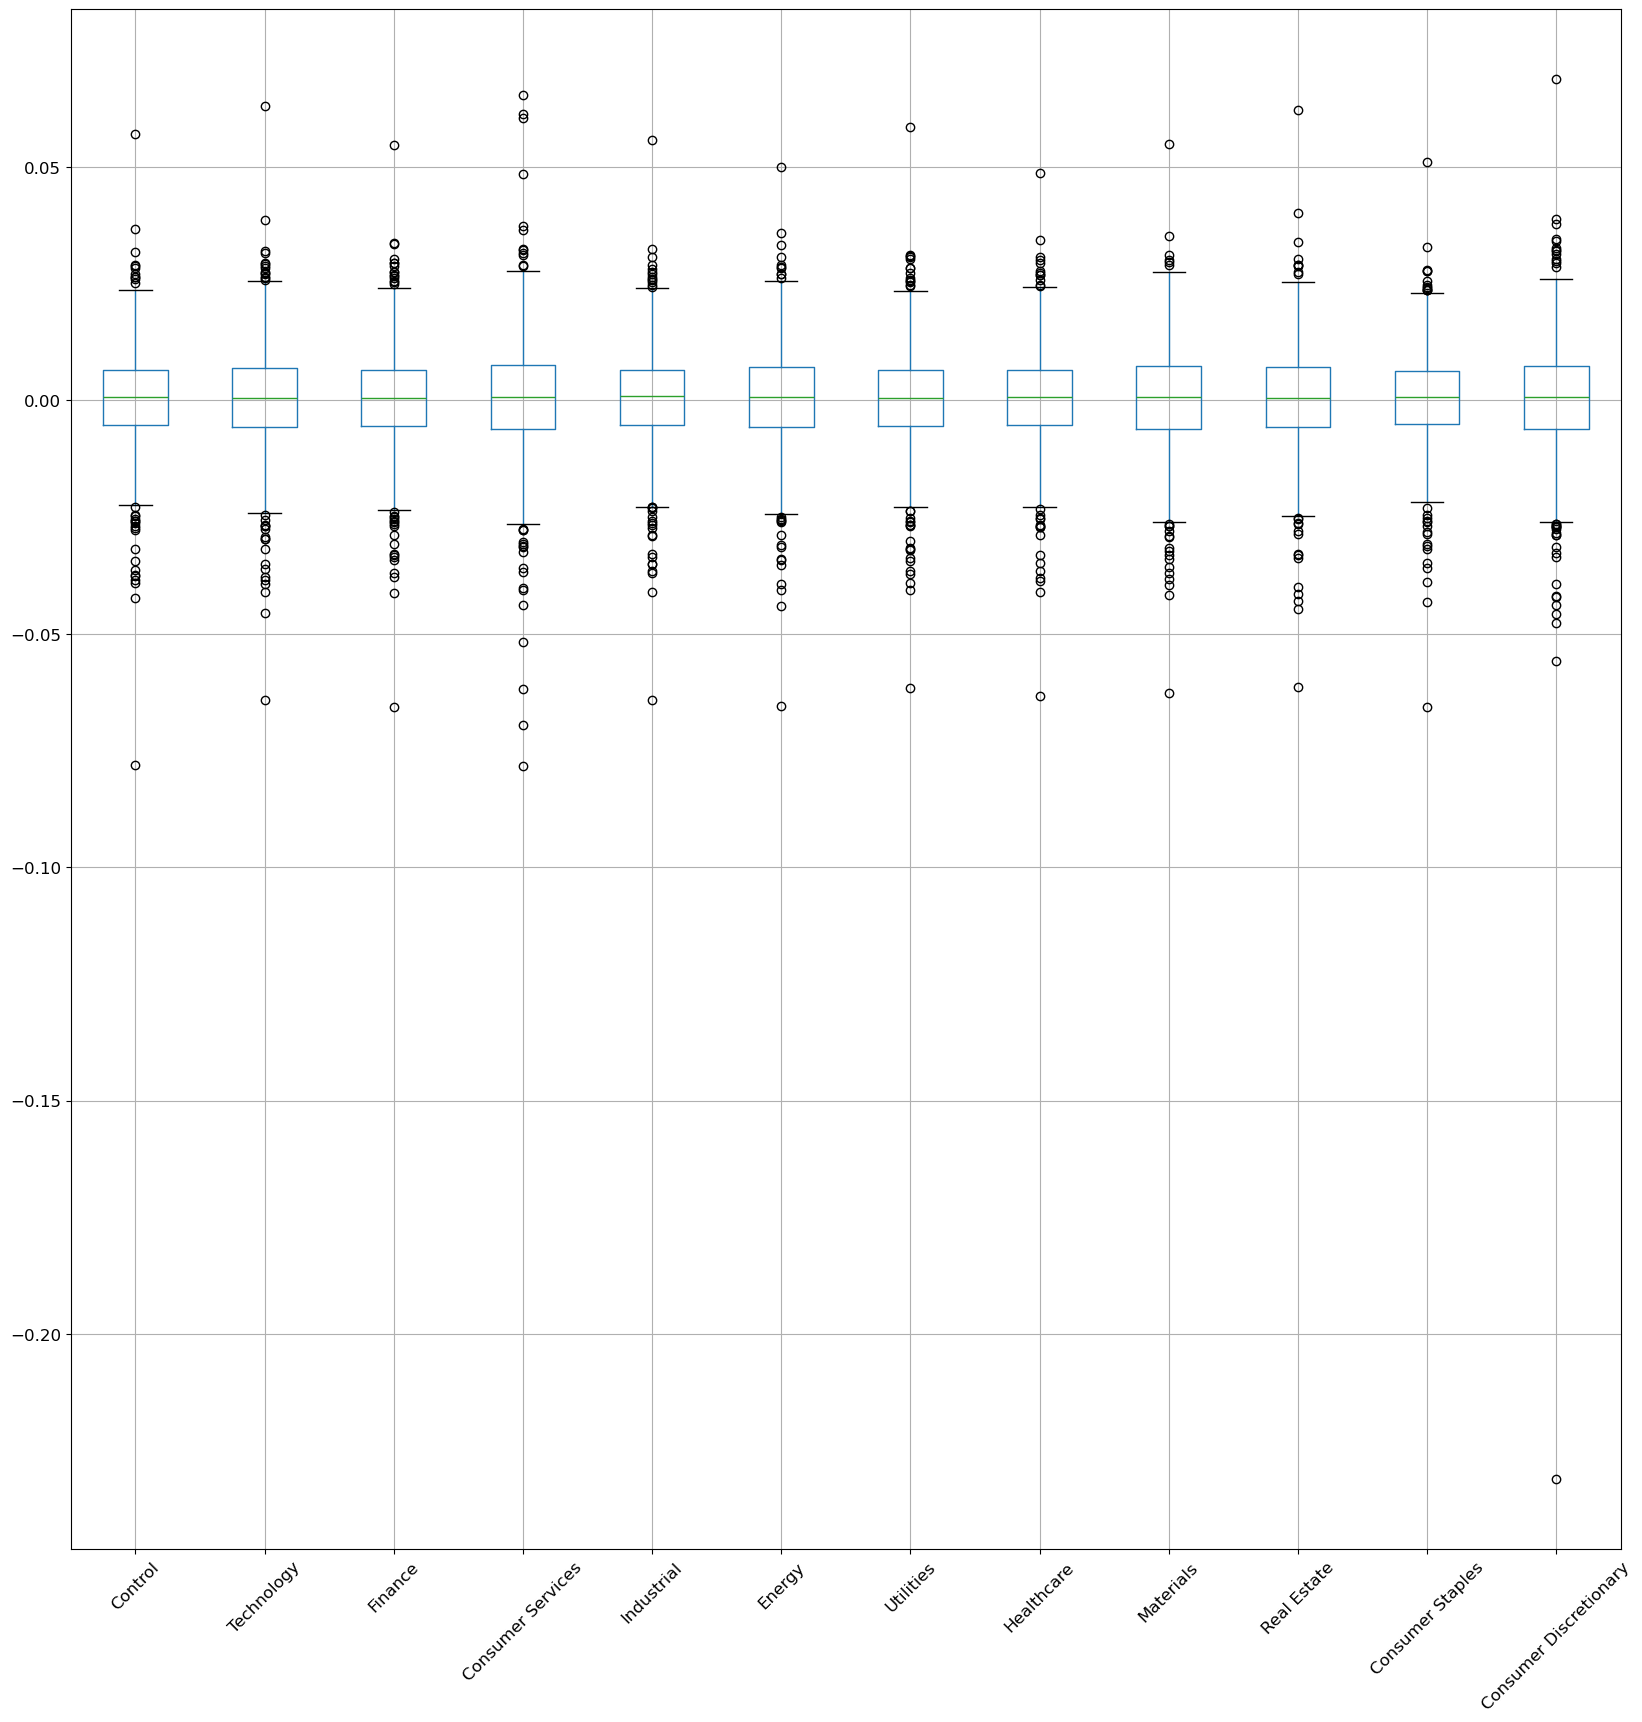

In [39]:
## Create a box plot for each of the returns.

# Box plot to visually show risk

all_returns_df.boxplot(column=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], figsize=(20,20), fontsize='large', rot=45)

In [40]:
## Calculate the Annualized Standard Deviation.
annualized_std = all_returns_df.std() * np.sqrt(252)
annualized_std.sort_values()

Consumer Staples          0.166595
Healthcare                0.167854
Industrial                0.175337
Energy                    0.177164
Finance                   0.177203
Control                   0.177557
Utilities                 0.177830
Real Estate               0.181447
Materials                 0.184282
Technology                0.186116
Consumer Services         0.210138
Consumer Discretionary    0.236854
dtype: float64

# Part V: Monte Carlo 5 year simulation with an initial investment of $20,000 for each portfolio

## Control 5 Year MC

In [41]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_control = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [42]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_control.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.989746  0.995317  1.021149  1.006216  0.989663  1.004883  1.004630   
2     0.992925  0.997830  1.023647  1.005605  0.988035  1.009434  1.003981   
3     0.979643  0.996610  1.020113  1.018881  0.978881  1.007979  0.999117   
4     0.995828  0.991962  1.024944  1.017323  0.976772  1.025305  1.006024   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.017621  1.275795  1.471005  1.359064  1.839565  1.484686  1.849189   
1257  1.022521  1.286649  1.466464  1.361207  1.845460  1.483854  1.842219   
1258  1.025075  1.285584  1.464220  1.361685  1.864562  1.496319  1.845782   
1259  1.030000  1.285638  1.447508  1.365865  1.844849  1.493572  1.839617   
1260  1.028243  1.289931  1.448134  1.366135  1.843822  1.486004  1.844173   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.001444  0.992713  1.003463  ...  1.005133  1.007715  0.998010   
2     1.004887  0.987637  0.994282  ...  1.005123  1.017153  0.992712   
3     1.001652  0.994058  0.994560  ...  1.010218  1.013392  0.987957   
4     1.001679  0.990115  1.008982  ...  1.004404  1.007136  0.990327   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.732675  1.259502  1.562784  ...  2.152435  1.747176  1.455758   
1257  1.722646  1.269191  1.557162  ...  2.166221  1.733697  1.444722   
1258  1.717136  1.268989  1.549723  ...  2.161743  1.739954  1.439203   
1259  1.700451  1.263924  1.562306  ...  2.159175  1.748279  1.444264   
1260  1.722453  1.263255  1.573365  ...  2.161863  1.768024  1.463983   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.003827  0.997117  0.996730  1.004090  1.000187  1.006865  1.004988  
2     1.007990  0.992244  0.996169  1.003389  1.000222  1.011034  0.998053  
3     1.017968  1.000900  0.992739  1.026478  0.999440  1.015510  1.000915  
4     1.009770  1.001963  0.995739  1.035245  1.000591  1.008855  1.004180  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.922382  0.953415  1.065094  2.387725  1.425992  1.411925  1.641751  
1257  1.935270  0.955293  1.064079  2.393467  1.427931  1.410379  1.653275  
1258  1.935980  0.953128  1.065886  2.406067  1.442827  1.441150  1.669136  
1259  1.945239  0.947088  1.075896  2.416908  1.431529  1.447192  1.676167  
1260  1.924287  0.938942  1.084518  2.426354  1.431907  1.435699  1.649084  

[1261 rows x 500 columns]

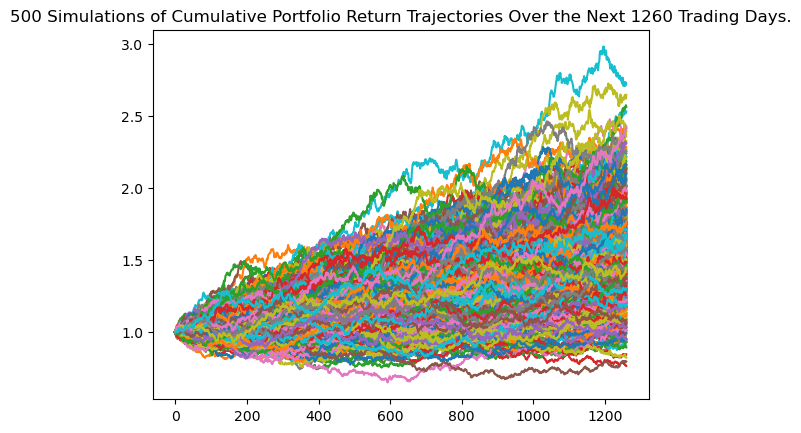

In [43]:
# Plot simulation outcomes
five_year_line_plot_control = MC_5_year_control.plot_simulation()

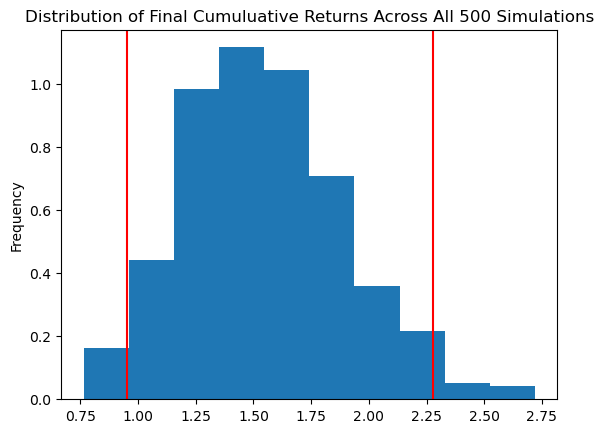

In [44]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_control = MC_5_year_control.plot_distribution()

In [45]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_control = MC_5_year_control.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_control)

count           500.000000
mean              1.545094
std               0.344079
min               0.765531
25%               1.297262
50%               1.514202
75%               1.761443
max               2.719081
95% CI Lower      0.950878
95% CI Upper      2.277523
Name: 1260, dtype: float64


In [46]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_control = round(five_year_summary_control.iloc[8]*initial_investment,2)
ci_upper_five_control = round(five_year_summary_control.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_control} and ${ci_upper_five_control}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $19017.56 and $45550.46


## Tech

In [47]:
MC_5_year_tech = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [48]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_tech.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.009792  0.995907  0.995065  0.999938  1.000240  1.003092  1.006571   
2     1.024350  0.993242  1.001868  1.003960  1.004216  1.014650  1.011895   
3     1.022620  0.988351  1.012835  0.996744  0.997568  1.019830  1.008922   
4     1.021152  0.994229  1.020835  0.995363  0.994926  1.028118  1.014472   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.856731  1.190158  1.811551  1.700468  1.268061  1.335928  1.852399   
1257  1.847808  1.200800  1.808515  1.705040  1.267346  1.341862  1.864941   
1258  1.853112  1.196478  1.810226  1.716327  1.259100  1.348178  1.885296   
1259  1.845725  1.200374  1.805740  1.727767  1.252863  1.356533  1.880847   
1260  1.865648  1.215011  1.840629  1.717749  1.246833  1.352153  1.911912   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.989589  0.999608  0.999703  ...  0.990979  1.005397  0.996855   
2     0.994415  0.995625  1.014120  ...  0.982807  1.009679  0.992139   
3     1.001491  1.007559  1.022582  ...  0.988276  0.999867  0.995137   
4     1.004282  1.009154  1.014879  ...  0.988673  1.005156  1.002189   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.907654  1.655021  1.330940  ...  1.280772  2.309526  1.609838   
1257  1.913467  1.656391  1.329147  ...  1.291269  2.318697  1.601939   
1258  1.921953  1.647876  1.321111  ...  1.293434  2.307315  1.614654   
1259  1.916757  1.654140  1.315486  ...  1.264707  2.325419  1.622308   
1260  1.912917  1.672299  1.308271  ...  1.270401  2.328364  1.629968   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.992926  1.003114  1.005507  0.995525  1.000893  1.000761  1.001241  
2     0.986750  1.015402  1.002046  0.999974  1.012815  1.005347  1.003690  
3     0.984293  1.016886  0.994074  0.995323  1.020422  1.003784  1.006307  
4     0.989136  1.018278  1.002384  0.990099  1.020465  0.993745  1.011229  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.606201  1.561454  2.752078  1.169986  2.494923  1.459516  2.225792  
1257  1.596001  1.569592  2.737860  1.180346  2.515685  1.463838  2.238625  
1258  1.595982  1.556537  2.743590  1.181382  2.483762  1.475551  2.257096  
1259  1.609250  1.530610  2.757604  1.181348  2.527541  1.476431  2.244121  
1260  1.627102  1.521503  2.735226  1.174033  2.542623  1.491624  2.246461  

[1261 rows x 500 columns]

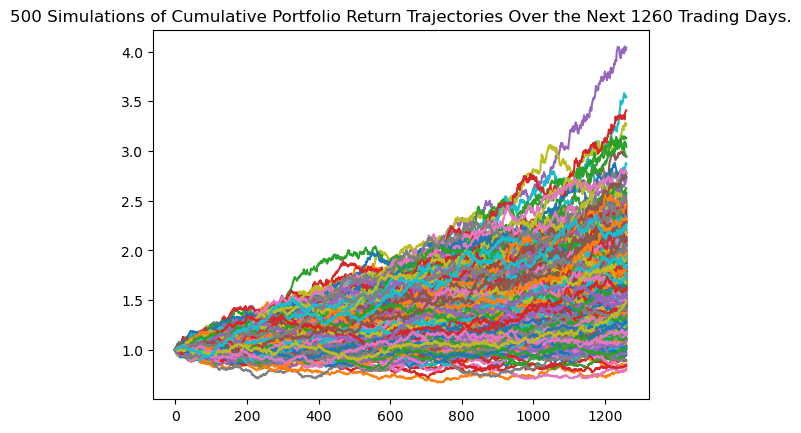

In [49]:
# Plot simulation outcomes
five_year_line_plot_tech = MC_5_year_tech.plot_simulation()

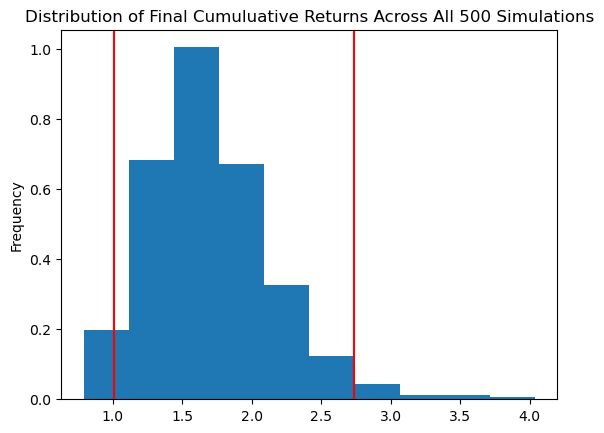

In [50]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_tech = MC_5_year_tech.plot_distribution()

In [51]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_tech = MC_5_year_tech.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_tech)

count           500.000000
mean              1.707486
std               0.448664
min               0.793790
25%               1.397983
50%               1.668946
75%               1.950514
max               4.037644
95% CI Lower      1.010533
95% CI Upper      2.736542
Name: 1260, dtype: float64


In [52]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_tech = round(five_year_summary_tech.iloc[8]*initial_investment,2)
ci_upper_five_tech = round(five_year_summary_tech.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_tech} and ${ci_upper_five_tech}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $20210.66 and $54730.83


## Fin

In [53]:
MC_5_year_fin = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [54]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_fin.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.995399  0.999190  1.005992  0.991213  0.991122  1.004580  1.006640   
2     1.001435  1.003400  1.011932  0.998981  0.994807  1.000108  1.001617   
3     1.003338  0.997089  1.013942  0.997946  1.002541  0.999013  0.997425   
4     1.003018  1.006132  1.015096  1.014340  1.003046  0.998746  0.995702   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.187705  1.566110  1.281247  1.672272  1.123610  1.608819  1.587336   
1257  1.198193  1.565973  1.277561  1.659711  1.125848  1.595748  1.577082   
1258  1.203019  1.564831  1.286925  1.641577  1.130392  1.587734  1.580479   
1259  1.214200  1.553928  1.287678  1.627598  1.112176  1.581700  1.585063   
1260  1.226848  1.533886  1.294606  1.636167  1.111831  1.583112  1.572913   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.993085  1.001042  0.998678  ...  1.004299  0.987594  0.997999   
2     0.995500  1.000447  1.010543  ...  1.020320  0.993772  0.988291   
3     1.005661  1.000558  1.013123  ...  1.014935  1.002493  0.987332   
4     1.015702  1.005855  1.019762  ...  1.024732  1.005196  0.992252   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.257766  1.741757  1.698947  ...  1.561111  1.518201  1.376631   
1257  1.272916  1.741255  1.700412  ...  1.561572  1.537806  1.378607   
1258  1.266846  1.720566  1.701652  ...  1.544465  1.539790  1.378187   
1259  1.276351  1.730233  1.693726  ...  1.564072  1.539588  1.387497   
1260  1.288313  1.742912  1.697344  ...  1.570793  1.534708  1.409803   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.989643  0.990143  1.008371  1.000378  0.999940  0.999172  1.009309  
2     0.987800  1.003888  1.026328  0.994146  1.008191  1.006446  1.012562  
3     0.998603  1.002690  1.034754  1.002142  0.999661  0.994892  1.018077  
4     1.006790  0.998401  1.036076  1.010992  1.000696  0.991627  1.022831  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.450452  1.148489  1.789462  1.759925  2.045964  1.690140  1.335686  
1257  1.468150  1.161941  1.786561  1.768615  2.046492  1.694982  1.319379  
1258  1.475597  1.172743  1.804776  1.792035  2.050957  1.689546  1.338193  
1259  1.448365  1.179022  1.791662  1.792000  2.033058  1.688588  1.338578  
1260  1.451088  1.188916  1.798805  1.778684  2.036954  1.701408  1.327198  

[1261 rows x 500 columns]

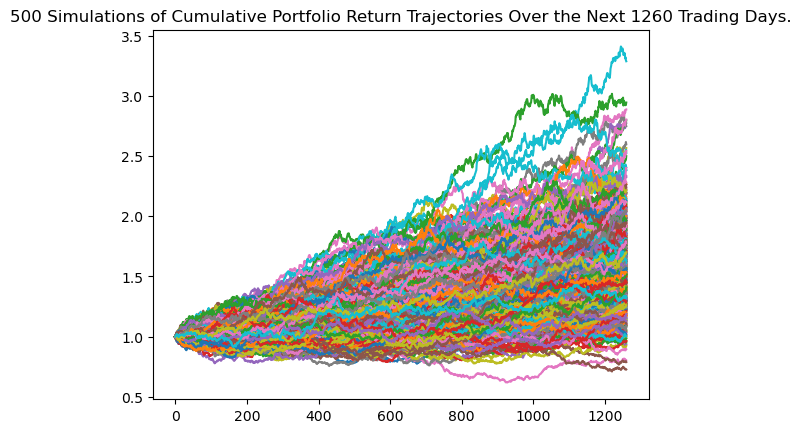

In [55]:
# Plot simulation outcomes
five_year_line_plot_fin = MC_5_year_fin.plot_simulation()

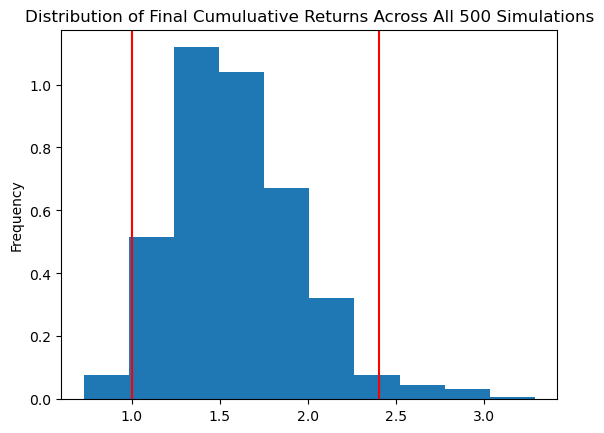

In [56]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_fin = MC_5_year_fin.plot_distribution()

In [57]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_fin = MC_5_year_fin.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_fin)

count           500.000000
mean              1.588192
std               0.369541
min               0.728662
25%               1.314097
50%               1.538771
75%               1.804013
max               3.286200
95% CI Lower      1.001059
95% CI Upper      2.402598
Name: 1260, dtype: float64


In [58]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_fin = round(five_year_summary_fin.iloc[8]*initial_investment,2)
ci_upper_five_fin = round(five_year_summary_fin.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_fin} and ${ci_upper_five_fin}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $20021.18 and $48051.96


## Con_ser

In [59]:
MC_5_year_con_ser = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [60]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_ser.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.998195  0.989976  1.000028  1.004290  0.996202  0.999241  1.013663   
2     0.999363  0.978497  1.012944  0.993924  0.994710  0.999895  1.015107   
3     0.999406  0.966058  1.019031  0.995042  0.996345  1.012647  1.028608   
4     1.018628  0.962791  1.015729  1.010858  0.990376  1.021598  1.023355   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.416035  1.211759  1.606793  1.679090  1.721238  1.743816  1.983754   
1257  1.425163  1.201981  1.593279  1.659961  1.721268  1.744324  2.011601   
1258  1.425723  1.223835  1.603434  1.676425  1.699385  1.755290  2.018611   
1259  1.413321  1.231836  1.605569  1.694912  1.688023  1.736606  1.971548   
1260  1.376025  1.223705  1.602931  1.691727  1.671314  1.757682  1.973997   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.002460  1.001063  0.997840  ...  1.013831  1.004036  1.001554   
2     1.019616  1.008777  0.996176  ...  0.994479  0.998639  1.000587   
3     1.013510  1.013039  0.985207  ...  1.000074  1.017314  1.007337   
4     1.022725  1.014637  0.984609  ...  1.002176  1.013231  1.015693   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.591127  1.433608  1.471586  ...  3.946035  2.556068  1.549654   
1257  1.607755  1.434113  1.460513  ...  3.899165  2.549365  1.582886   
1258  1.596362  1.415384  1.485266  ...  3.866748  2.568057  1.567217   
1259  1.611927  1.420722  1.493891  ...  3.869895  2.592676  1.560599   
1260  1.637905  1.401643  1.492356  ...  3.943772  2.609817  1.568866   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.995957  1.003160  1.018869  0.997297  0.997032  0.995012  0.992304  
2     0.991301  1.001191  1.026483  1.006950  0.976284  1.003671  0.985500  
3     0.988277  1.006642  1.035355  1.001980  0.974083  1.003369  0.984474  
4     0.978888  1.007871  1.040064  0.996807  0.977173  1.007573  0.985344  
...        ...       ...       ...       ...       ...       ...       ...  
1256  0.867006  2.870639  1.391559  1.938252  2.083147  1.743366  2.251848  
1257  0.876049  2.872135  1.422193  1.922749  2.124112  1.771056  2.269355  
1258  0.876453  2.863460  1.430736  1.913325  2.122188  1.786749  2.268160  
1259  0.883673  2.827858  1.424596  1.927629  2.100498  1.785794  2.276153  
1260  0.871544  2.817465  1.418688  1.914370  2.108621  1.770715  2.277030  

[1261 rows x 500 columns]

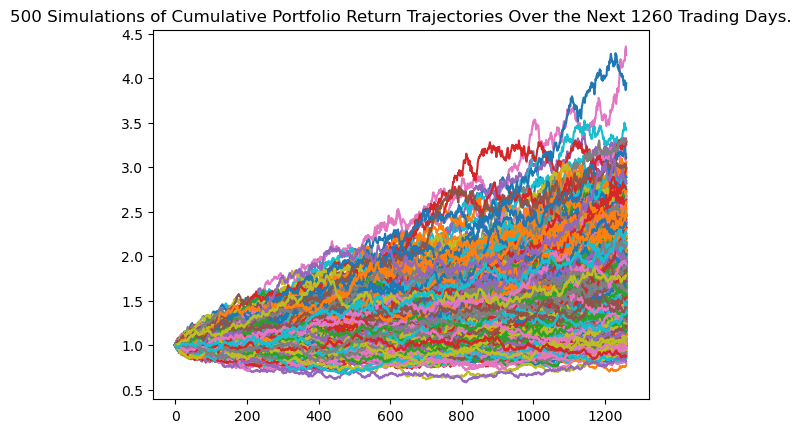

In [61]:
# Plot simulation outcomes
five_year_line_plot_con_ser = MC_5_year_con_ser.plot_simulation()

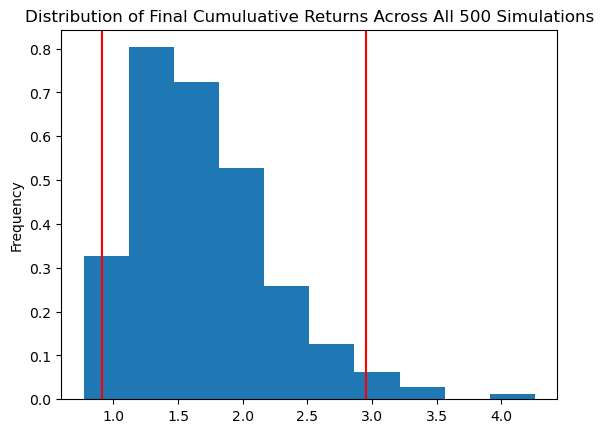

In [62]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_con_ser = MC_5_year_con_ser.plot_distribution()

In [63]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_ser = MC_5_year_con_ser.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_con_ser)

count           500.000000
mean              1.701627
std               0.537346
min               0.772346
25%               1.319176
50%               1.611518
75%               1.998518
max               4.258527
95% CI Lower      0.914652
95% CI Upper      2.956206
Name: 1260, dtype: float64


In [64]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_con_ser = round(five_year_summary_con_ser.iloc[8]*initial_investment,2)
ci_upper_five_con_ser = round(five_year_summary_con_ser.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_con_ser} and ${ci_upper_five_con_ser}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $18293.03 and $59124.12


## Industrial

In [65]:
MC_5_year_ind= MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [66]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_ind.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.998809  0.992713  0.993888  1.006609  1.011393  1.002401  1.003297   
2     0.991342  0.988436  0.992342  0.995953  1.011899  0.996371  1.011068   
3     0.986419  0.982221  0.991416  0.998297  1.014208  1.004550  1.011806   
4     0.986711  0.978505  0.999954  0.992871  1.019388  1.000948  1.003510   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.477638  1.402922  2.002167  1.136248  1.516093  1.642541  1.563017   
1257  1.474917  1.405004  2.020651  1.134362  1.513836  1.651754  1.576211   
1258  1.472450  1.417520  2.029742  1.134348  1.520835  1.648907  1.581556   
1259  1.477884  1.409827  2.035972  1.128066  1.521388  1.657524  1.583633   
1260  1.478930  1.428476  2.039034  1.132942  1.530156  1.668089  1.572775   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.008431  1.012617  1.004897  ...  1.009272  0.997601  1.009006   
2     1.012327  1.008776  1.003489  ...  1.006985  0.998292  1.000783   
3     1.022659  0.994851  1.000789  ...  1.002481  1.011389  1.003895   
4     1.018991  1.009607  0.998011  ...  1.005635  1.012136  1.001074   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.478612  1.598649  2.363934  ...  1.390077  1.561793  1.564105   
1257  1.462210  1.591250  2.377841  ...  1.392992  1.561236  1.560828   
1258  1.463619  1.592620  2.393301  ...  1.386818  1.562760  1.584859   
1259  1.467582  1.597342  2.378438  ...  1.378947  1.553699  1.588593   
1260  1.472878  1.603283  2.392446  ...  1.368757  1.530749  1.585248   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.003681  1.009350  1.012107  1.001871  0.991617  1.003246  1.002863  
2     0.991590  1.009399  1.013026  0.998571  0.992748  1.007302  1.009941  
3     0.998981  1.004254  1.014561  0.999356  0.990230  1.004924  1.010284  
4     1.003380  1.010861  1.013480  1.001797  0.985053  1.001712  1.008060  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.086154  1.046135  1.150439  3.028196  1.012646  1.809467  1.490339  
1257  1.085789  1.062936  1.145427  3.020751  1.007841  1.828646  1.482557  
1258  1.078340  1.056786  1.149367  3.031615  1.000435  1.822977  1.468001  
1259  1.083689  1.052829  1.150398  3.070725  1.004497  1.844736  1.467594  
1260  1.084069  1.059192  1.164493  3.065732  1.012490  1.843342  1.465253  

[1261 rows x 500 columns]

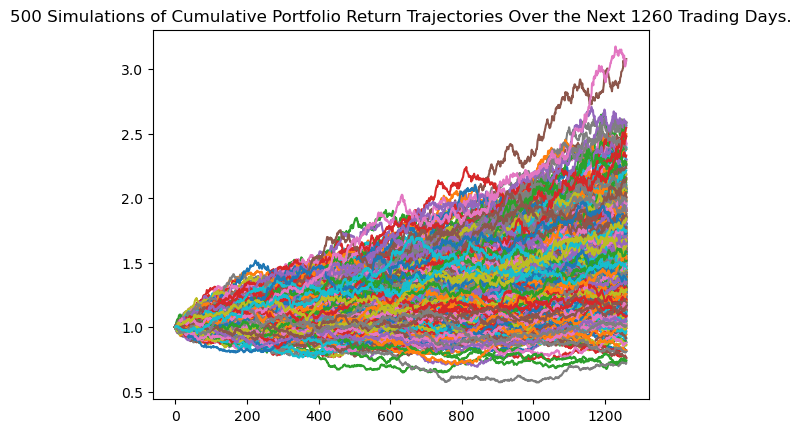

In [67]:
# Plot simulation outcomes
five_year_line_plot_ind = MC_5_year_ind.plot_simulation()

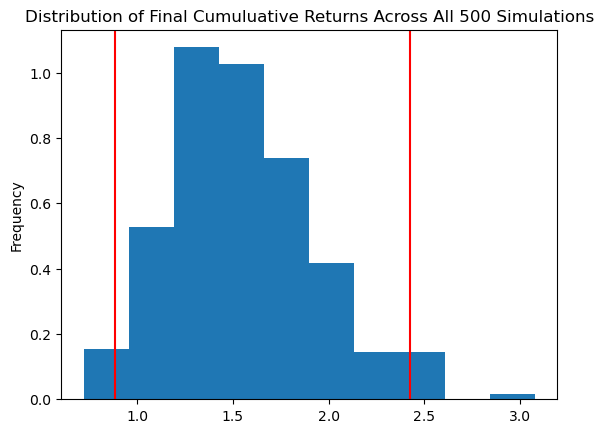

In [68]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_ind = MC_5_year_ind.plot_distribution()

In [69]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_ind = MC_5_year_ind.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_ind)

count           500.000000
mean              1.555397
std               0.379749
min               0.721375
25%               1.295371
50%               1.520815
75%               1.758648
max               3.077918
95% CI Lower      0.884074
95% CI Upper      2.423718
Name: 1260, dtype: float64


In [70]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_ind = round(five_year_summary_ind.iloc[8]*initial_investment,2)
ci_upper_five_ind = round(five_year_summary_ind.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_ind} and ${ci_upper_five_ind}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $17681.47 and $48474.36


## energy

In [71]:
MC_5_year_nrg = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [72]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_nrg.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.016682  1.002591  1.002577  0.994229  0.991667  1.025000  1.005507   
2     1.018276  1.010762  1.011280  0.985754  1.005292  1.031749  1.001417   
3     1.016330  1.012067  1.012102  0.991028  1.005907  1.034742  0.987382   
4     1.021942  1.014227  1.003438  0.989121  0.995266  1.029623  0.995875   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.736576  1.609201  1.356185  1.366631  2.248335  1.948930  1.815621   
1257  2.725083  1.598663  1.339793  1.353585  2.243069  1.941350  1.802309   
1258  2.719261  1.613023  1.339002  1.359594  2.214521  1.923258  1.811285   
1259  2.708780  1.605751  1.327447  1.373675  2.216733  1.898425  1.805914   
1260  2.706072  1.600661  1.340183  1.350175  2.213493  1.906335  1.809815   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.989217  0.993966  0.994724  ...  1.008718  1.003127  0.995235   
2     0.999919  0.998031  0.995369  ...  1.004855  0.998550  0.992368   
3     1.001966  0.998727  0.996505  ...  1.003157  0.991070  1.004671   
4     1.006618  1.007396  0.992222  ...  1.013679  0.988262  1.005601   
...        ...       ...       ...  ...       ...       ...       ...   
1256  2.098144  2.266324  2.759629  ...  2.152899  1.957382  2.077082   
1257  2.077227  2.287008  2.738999  ...  2.160181  1.956325  2.070346   
1258  2.055904  2.279477  2.747107  ...  2.151351  1.961859  2.060102   
1259  2.047248  2.314511  2.784234  ...  2.160245  1.949482  2.062114   
1260  2.025864  2.312131  2.751527  ...  2.151286  1.942509  2.051796   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.007876  1.008218  1.002990  1.007046  1.012467  1.005709  1.010741  
2     1.010317  0.999637  1.000758  1.007838  1.026860  1.013736  1.018305  
3     1.003027  0.997659  1.002712  0.997981  1.019760  1.005616  1.002670  
4     1.008198  1.002674  1.004826  1.006071  1.029580  1.009360  0.998668  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.304916  1.347268  1.483630  2.028169  2.648853  1.450187  1.434887  
1257  1.298284  1.335045  1.470947  2.015289  2.634665  1.464157  1.445065  
1258  1.285414  1.352609  1.476155  2.026585  2.615330  1.460134  1.447535  
1259  1.296811  1.355936  1.507642  2.043946  2.607282  1.453895  1.459325  
1260  1.307755  1.352112  1.510090  2.043279  2.611828  1.455197  1.442636  

[1261 rows x 500 columns]

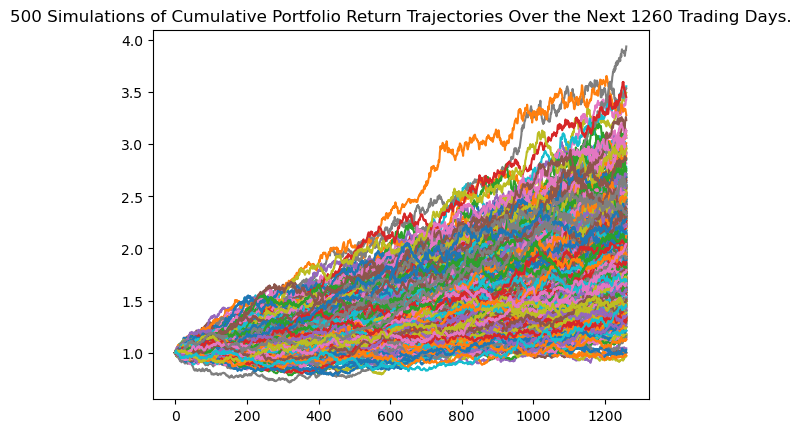

In [73]:
# Plot simulation outcomes
five_year_line_plot_nrg = MC_5_year_nrg.plot_simulation()

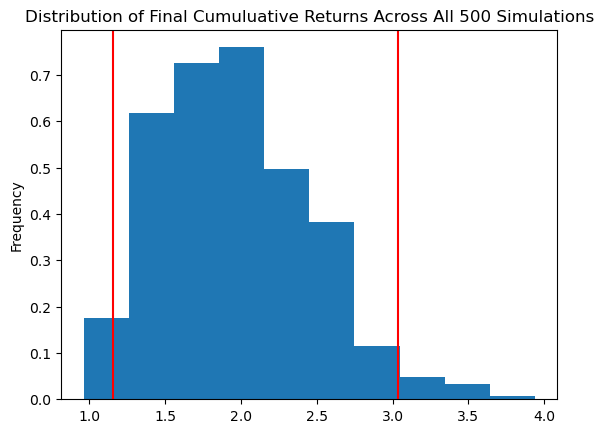

In [74]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_nrg = MC_5_year_nrg.plot_distribution()

In [75]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_nrg = MC_5_year_nrg.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_nrg)

count           500.000000
mean              1.965786
std               0.499329
min               0.964621
25%               1.580522
50%               1.934937
75%               2.304513
max               3.938783
95% CI Lower      1.159012
95% CI Upper      3.037229
Name: 1260, dtype: float64


In [76]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_control = round(five_year_summary_nrg.iloc[8]*initial_investment,2)
ci_upper_five_control = round(five_year_summary_nrg.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_control} and ${ci_upper_five_control}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $23180.25 and $60744.58


## utilities

In [77]:
MC_5_year_util = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [78]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_util.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.015511  1.010933  1.003675  0.995147  1.010861  0.993664  1.003413   
2     1.017256  1.014271  0.999690  0.998487  1.014093  0.991097  0.996602   
3     1.024452  1.011211  1.000574  1.005369  1.012573  0.998802  0.995615   
4     1.012959  1.014777  0.992959  0.999113  0.998247  1.012380  0.978697   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.278078  1.247763  1.719125  1.001373  0.914093  2.669965  1.096729   
1257  1.274663  1.248768  1.725071  0.994989  0.908599  2.637695  1.097359   
1258  1.277232  1.265451  1.715106  0.993267  0.909950  2.661059  1.108799   
1259  1.279522  1.263998  1.730003  0.999606  0.911949  2.647817  1.109761   
1260  1.288850  1.261737  1.708393  0.994529  0.903092  2.700671  1.114494   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.994080  1.005839  1.003589  ...  0.996716  0.998663  1.005051   
2     0.989398  1.001201  0.995651  ...  0.999441  1.000832  1.018298   
3     0.987566  1.000451  0.990213  ...  0.994651  1.003844  1.024871   
4     0.984007  0.997615  0.995468  ...  0.991929  0.999513  1.018979   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.425112  1.065245  2.437194  ...  1.152848  1.025212  1.240761   
1257  1.439731  1.068092  2.434449  ...  1.147917  1.027229  1.227600   
1258  1.431742  1.063405  2.438906  ...  1.144583  1.031508  1.224351   
1259  1.443598  1.053043  2.438483  ...  1.170498  1.030630  1.237609   
1260  1.432585  1.058059  2.440453  ...  1.167584  1.033408  1.218550   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.998533  0.991927  1.008203  0.995848  1.000515  0.989401  1.002827  
2     1.003263  0.998999  1.004781  0.993271  0.999564  0.993767  1.008339  
3     1.012229  1.001148  1.005805  0.988082  0.990717  0.983377  1.014378  
4     1.016263  0.987493  0.989100  0.995399  0.997665  0.985783  1.009664  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.673171  1.989870  1.611312  0.843280  1.421372  1.106792  1.591448  
1257  1.676823  1.990023  1.619082  0.846797  1.402576  1.109638  1.577056  
1258  1.657224  1.992031  1.639495  0.836304  1.407627  1.116254  1.564583  
1259  1.672120  1.984873  1.654034  0.841517  1.405322  1.131268  1.553504  
1260  1.670462  1.995477  1.655431  0.849956  1.398788  1.128779  1.526541  

[1261 rows x 500 columns]

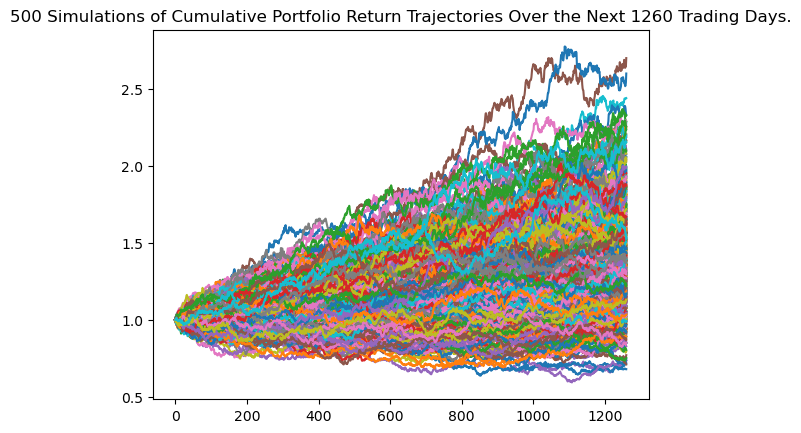

In [79]:
# Plot simulation outcomes
five_year_line_plot_util = MC_5_year_util.plot_simulation()

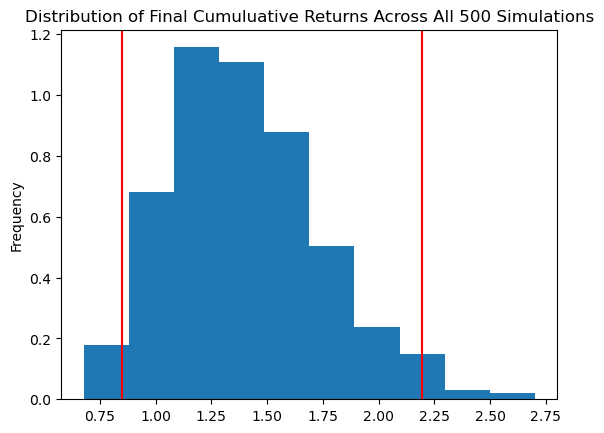

In [80]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_util = MC_5_year_util.plot_distribution()

In [81]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_util = MC_5_year_util.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_util)

count           500.000000
mean              1.403554
std               0.344508
min               0.678976
25%               1.153457
50%               1.362263
75%               1.623719
max               2.700671
95% CI Lower      0.850240
95% CI Upper      2.193353
Name: 1260, dtype: float64


In [82]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_util = round(five_year_summary_util.iloc[8]*initial_investment,2)
ci_upper_five_util = round(five_year_summary_util.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_util} and ${ci_upper_five_util}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $17004.8 and $43867.06


## Healthcare

In [83]:
MC_5_year_hc = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [84]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_hc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.991885  1.000671  1.005339  0.999634  1.005647  0.999173  1.003746   
2     0.984608  0.997948  1.007500  0.997476  1.006097  0.997722  1.008694   
3     0.980037  0.994356  1.008587  0.992383  1.007855  1.009672  1.006337   
4     0.980566  0.998491  1.010121  0.990216  1.007377  1.002630  1.012605   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.171784  1.477414  2.072391  1.663875  1.237941  1.867768  1.707751   
1257  2.173241  1.480146  2.053146  1.671266  1.241472  1.863687  1.705717   
1258  2.220338  1.477561  2.060690  1.688398  1.242640  1.871463  1.700182   
1259  2.229257  1.463404  2.078143  1.673919  1.240441  1.873394  1.685363   
1260  2.251272  1.461758  2.089521  1.657580  1.237747  1.865942  1.691804   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.996697  1.005518  0.987972  ...  0.999114  0.987238  0.998713   
2     1.002569  0.998595  0.988567  ...  0.998366  0.986297  1.000491   
3     0.996136  0.993582  0.989916  ...  1.006932  0.982114  1.001691   
4     1.001669  1.006404  0.994232  ...  1.005962  0.996596  0.996241   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.267386  1.721107  1.365291  ...  2.590175  1.125065  1.300617   
1257  1.270060  1.724509  1.370449  ...  2.577729  1.118436  1.296609   
1258  1.275379  1.698291  1.377099  ...  2.587188  1.123256  1.300249   
1259  1.280456  1.709882  1.390765  ...  2.598704  1.122872  1.291851   
1260  1.272086  1.697645  1.382717  ...  2.636774  1.127757  1.291578   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.000277  1.000646  1.007027  1.005788  0.999371  0.995131  0.997947  
2     1.000017  0.998307  1.012636  0.998968  0.996992  0.997271  1.002362  
3     0.996466  0.998398  1.013540  1.007514  0.994039  0.993663  1.010628  
4     1.007169  1.009096  1.018834  1.006668  1.001773  0.995359  1.011767  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.530100  2.248171  1.320876  1.538228  1.458538  2.198282  1.639378  
1257  1.547002  2.253640  1.318712  1.522121  1.457989  2.179872  1.641450  
1258  1.569834  2.251747  1.337686  1.529197  1.460151  2.183415  1.639596  
1259  1.565600  2.257048  1.323780  1.528468  1.463887  2.171454  1.631578  
1260  1.558315  2.258889  1.342821  1.514106  1.470954  2.192861  1.630710  

[1261 rows x 500 columns]

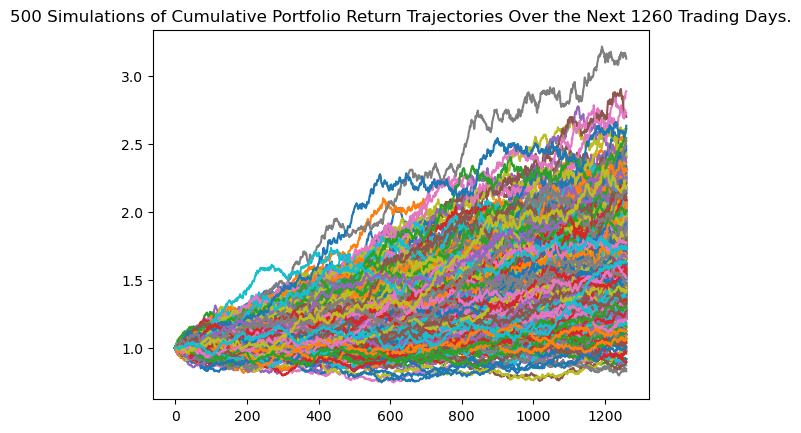

In [85]:
# Plot simulation outcomes
five_year_line_plot_hc = MC_5_year_hc.plot_simulation()

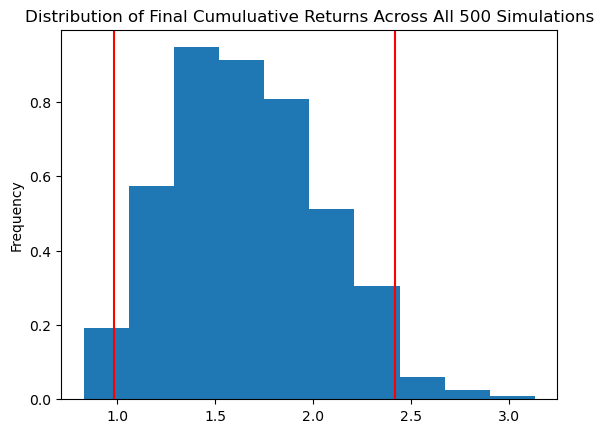

In [86]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_hc = MC_5_year_hc.plot_distribution()

In [87]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_hc = MC_5_year_hc.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_hc)

count           500.000000
mean              1.658664
std               0.382421
min               0.828834
25%               1.375493
50%               1.622766
75%               1.918150
max               3.130032
95% CI Lower      0.981175
95% CI Upper      2.417360
Name: 1260, dtype: float64


In [88]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_hc = round(five_year_summary_hc.iloc[8]*initial_investment,2)
ci_upper_five_hc = round(five_year_summary_hc.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_hc} and ${ci_upper_five_hc}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $19623.49 and $48347.21


## Materials

In [89]:
MC_5_year_mat = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [90]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_mat.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.991107  1.001736  1.005022  1.007379  1.006589  1.008118  1.009219   
2     0.978987  1.004296  1.002704  1.011551  0.993632  1.011086  0.999677   
3     0.980474  1.004943  0.999615  1.014902  0.985997  1.019234  0.992780   
4     0.969024  1.008243  0.991815  1.000280  1.002380  1.013911  0.995329   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.759493  1.335191  1.305736  1.494116  2.202387  1.325380  0.919701   
1257  1.756751  1.332554  1.307685  1.482659  2.199993  1.316014  0.921887   
1258  1.772760  1.327184  1.304536  1.477111  2.204622  1.315853  0.928665   
1259  1.756438  1.335434  1.312344  1.480035  2.193023  1.300466  0.932113   
1260  1.758518  1.333815  1.301222  1.464941  2.212957  1.294366  0.930733   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.001770  1.002552  1.014500  ...  1.008458  0.995157  0.995414   
2     0.997551  0.998423  1.015066  ...  1.007936  0.991244  0.990575   
3     0.982412  1.004409  1.010936  ...  1.002137  0.982531  0.988182   
4     0.983737  1.000633  1.000667  ...  0.991011  0.981379  0.994827   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.742936  1.930039  2.065016  ...  1.471301  1.447807  1.533427   
1257  1.762922  1.950391  2.041105  ...  1.489306  1.448688  1.519399   
1258  1.789293  1.954703  2.064232  ...  1.490081  1.453792  1.504936   
1259  1.789637  1.958496  2.026561  ...  1.528158  1.460181  1.510446   
1260  1.791870  1.947702  2.036478  ...  1.514801  1.461512  1.510814   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.004672  0.998268  0.987856  1.013361  0.999403  1.002310  0.998658  
2     0.992669  0.991405  0.984587  1.017863  0.999766  1.000292  1.004579  
3     0.993685  0.995920  0.987121  1.018571  0.997877  0.999630  1.003162  
4     0.988389  0.999268  0.988740  1.011085  0.990738  0.998320  0.999080  
...        ...       ...       ...       ...       ...       ...       ...  
1256  2.608506  1.338166  0.998422  1.329516  1.889420  1.227084  1.673066  
1257  2.636338  1.324446  1.003454  1.311679  1.882856  1.230454  1.676398  
1258  2.615789  1.323485  1.018054  1.322608  1.896257  1.221042  1.650506  
1259  2.600817  1.325266  1.022611  1.325163  1.898823  1.226534  1.651584  
1260  2.602067  1.335390  1.021134  1.324330  1.916589  1.232859  1.639517  

[1261 rows x 500 columns]

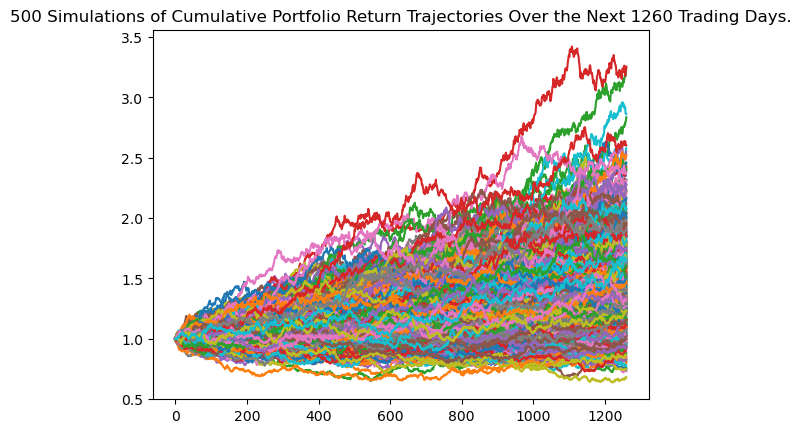

In [91]:
# Plot simulation outcomes
five_year_line_plot_mat = MC_5_year_mat.plot_simulation()

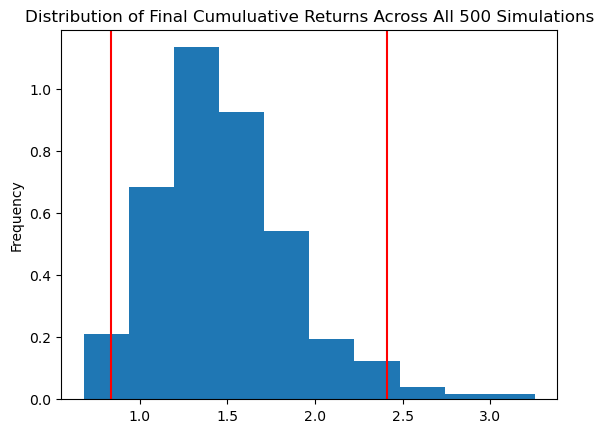

In [92]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_mat = MC_5_year_mat.plot_distribution()

In [93]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_mat = MC_5_year_mat.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_mat)

count           500.000000
mean              1.477745
std               0.393616
min               0.681282
25%               1.216635
50%               1.430699
75%               1.690065
max               3.255073
95% CI Lower      0.836564
95% CI Upper      2.412156
Name: 1260, dtype: float64


In [94]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_mat = round(five_year_summary_mat.iloc[8]*initial_investment,2)
ci_upper_five_mat = round(five_year_summary_mat.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_mat} and ${ci_upper_five_mat}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $16731.27 and $48243.12


## Real Estate

In [95]:
MC_5_year_re = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)


In [96]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_re.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.003217  1.001980  0.997787  0.998292  1.000453  0.996979  1.005108   
2     1.007052  1.000132  0.998432  0.993394  1.012332  0.989048  1.006223   
3     1.003110  1.003558  1.018962  1.008629  1.014125  0.983276  1.017378   
4     1.010252  1.007157  1.022681  1.021415  1.009288  0.985946  1.025897   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.441303  1.912207  1.408267  1.578545  1.765832  1.665877  1.565694   
1257  1.429921  1.911524  1.400305  1.587469  1.773798  1.675347  1.554058   
1258  1.418035  1.925860  1.394127  1.608986  1.771727  1.694229  1.573036   
1259  1.399296  1.910060  1.388836  1.604357  1.786063  1.713381  1.569320   
1260  1.407184  1.891470  1.391543  1.613301  1.781768  1.723304  1.575293   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.994126  1.009268  0.993378  ...  0.992988  0.989090  1.002968   
2     0.997770  1.026741  0.991258  ...  0.991135  0.992789  1.002163   
3     0.997878  1.030385  0.981935  ...  0.993872  0.991142  0.996811   
4     0.992248  1.023323  0.978252  ...  0.998319  0.986465  0.999476   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.466499  1.502911  1.239847  ...  2.107613  1.399866  2.140688   
1257  1.471379  1.494422  1.253057  ...  2.118661  1.411422  2.147447   
1258  1.479830  1.504574  1.232366  ...  2.123133  1.414820  2.140668   
1259  1.487259  1.517396  1.225859  ...  2.109886  1.412713  2.130825   
1260  1.485881  1.530597  1.232823  ...  2.088040  1.420157  2.145929   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.991349  1.021503  1.004897  1.004100  0.998438  0.994781  0.998550  
2     0.999468  1.029019  1.008086  1.009125  0.998035  0.999104  0.995241  
3     1.001618  1.031438  1.002617  1.008720  1.003983  1.007666  0.982181  
4     1.010945  1.032711  0.997524  0.999058  1.018897  1.010072  0.964853  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.052172  1.030206  1.270409  1.184407  1.364396  1.695653  1.512367  
1257  1.056062  1.025405  1.265690  1.179962  1.365590  1.691062  1.507039  
1258  1.050255  1.017995  1.259775  1.171516  1.368406  1.673877  1.505803  
1259  1.041215  1.008702  1.263095  1.160360  1.377013  1.690820  1.505611  
1260  1.031095  1.009968  1.267584  1.172692  1.363004  1.703275  1.501866  

[1261 rows x 500 columns]

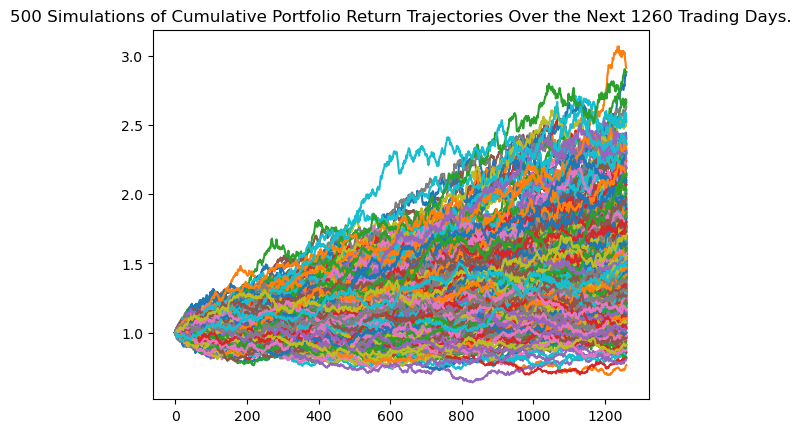

In [97]:
# Plot simulation outcomes
five_year_line_plot_re = MC_5_year_re.plot_simulation()

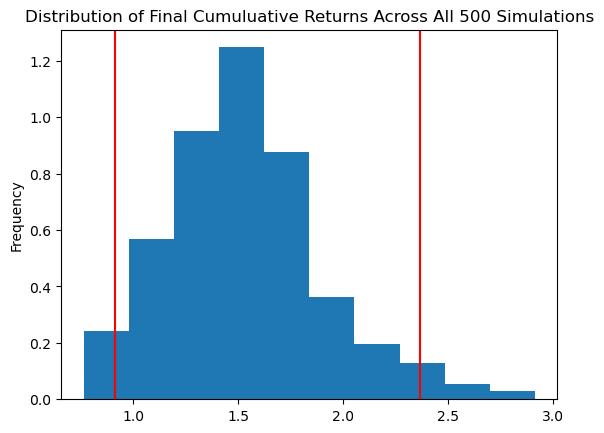

In [98]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_re = MC_5_year_re.plot_distribution()

In [99]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_re = MC_5_year_re.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_re)

count           500.000000
mean              1.529304
std               0.370218
min               0.764612
25%               1.274475
50%               1.494414
75%               1.740221
max               2.912509
95% CI Lower      0.912822
95% CI Upper      2.364267
Name: 1260, dtype: float64


In [100]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_re = round(five_year_summary_re.iloc[8]*initial_investment,2)
ci_upper_five_re = round(five_year_summary_re.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_re} and ${ci_upper_five_re}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $18256.44 and $47285.35


## Consumer Staples

In [101]:
MC_5_year_con_staple = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [102]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_staple.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.003990  0.994978  0.999716  1.001187  1.004020  0.997181  1.001537   
2     1.011780  1.002098  0.997945  0.999616  1.006813  0.999084  1.007118   
3     1.015099  1.000052  0.990807  0.998000  1.006443  1.007153  1.006383   
4     1.018216  0.989394  0.993592  1.001819  1.010846  1.012015  1.005651   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.431684  1.288953  1.175881  1.832944  2.283270  1.699252  1.361260   
1257  1.443052  1.291311  1.172867  1.828317  2.280470  1.731902  1.372621   
1258  1.459020  1.286085  1.159727  1.807657  2.267983  1.727527  1.365007   
1259  1.452575  1.273423  1.159847  1.816922  2.252661  1.741041  1.366764   
1260  1.460115  1.270893  1.143643  1.798483  2.249944  1.728059  1.373136   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.008464  1.001167  0.995913  ...  0.995166  1.002138  1.005862   
2     1.016399  1.007362  1.005146  ...  0.988727  1.009052  1.016005   
3     1.025660  1.008677  1.012908  ...  0.983780  1.009829  1.013809   
4     1.013929  1.007582  1.012666  ...  0.988231  1.002896  1.010922   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.248208  1.428292  1.885118  ...  1.906326  1.497257  1.300080   
1257  1.258624  1.430995  1.892334  ...  1.921184  1.510726  1.307863   
1258  1.241429  1.429166  1.883961  ...  1.908110  1.511443  1.295546   
1259  1.241495  1.436982  1.882925  ...  1.899375  1.502625  1.301782   
1260  1.252464  1.433826  1.891082  ...  1.905390  1.506794  1.300678   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.995573  0.985971  0.996988  1.001587  0.998939  1.010563  1.006291  
2     0.994350  0.975694  0.996829  0.993373  1.002807  1.023072  1.007988  
3     0.988085  0.976955  0.992217  0.998199  1.005561  1.028510  1.016953  
4     0.981089  0.975308  0.997127  1.000291  1.007004  1.026831  1.019039  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.963250  1.223501  1.268688  1.642929  1.365168  1.451124  1.325951  
1257  1.960645  1.230156  1.262556  1.644927  1.364006  1.456410  1.324476  
1258  1.976398  1.232846  1.261975  1.638868  1.364420  1.468965  1.329523  
1259  1.982379  1.230892  1.258023  1.649639  1.358110  1.456368  1.327542  
1260  1.982447  1.239252  1.265769  1.651944  1.370074  1.476725  1.330695  

[1261 rows x 500 columns]

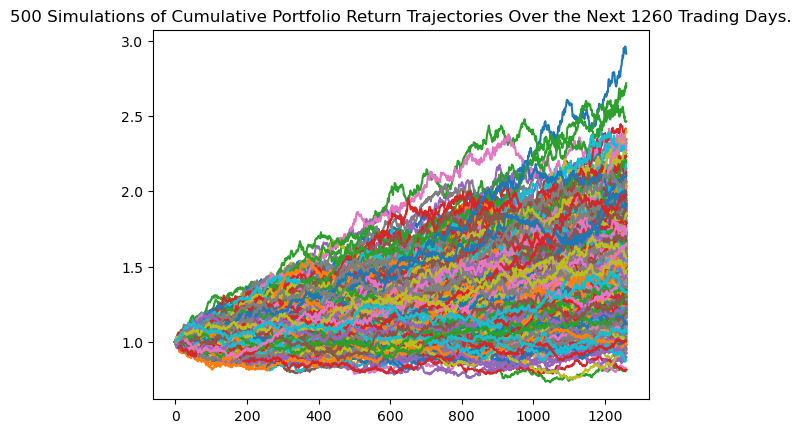

In [103]:
# Plot simulation outcomes
five_year_line_plot_con_staple = MC_5_year_con_staple.plot_simulation()

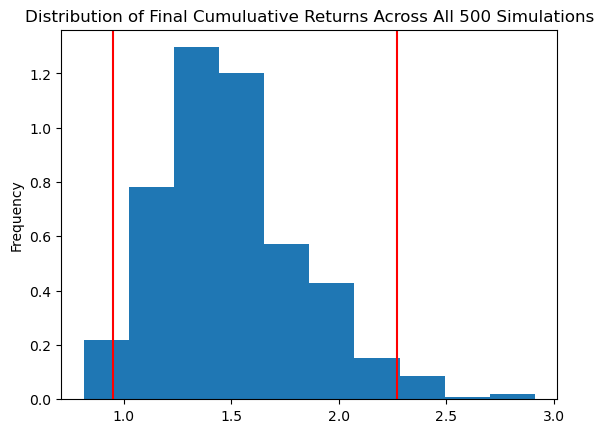

In [104]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_con_staple = MC_5_year_con_staple.plot_distribution()

In [105]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_staple = MC_5_year_con_staple.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_con_staple)

count           500.000000
mean              1.496874
std               0.331687
min               0.814324
25%               1.269997
50%               1.452708
75%               1.673559
max               2.912904
95% CI Lower      0.951729
95% CI Upper      2.270771
Name: 1260, dtype: float64


In [106]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_con_staple = round(five_year_summary_con_staple.iloc[8]*initial_investment,2)
ci_upper_five_con_staple = round(five_year_summary_con_staple.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_con_staple} and ${ci_upper_five_con_staple}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $19034.57 and $45415.43


## Consumer Discretionary

In [107]:
MC_5_year_con_disc = MCSimulation(
    portfolio_data = portfolio_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.25],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [108]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_disc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.989668  1.005220  1.011430  0.996423  1.004340  0.991360  0.998976   
2     0.968505  1.005943  1.003942  1.004254  0.990179  0.987534  1.009857   
3     0.955571  0.989256  0.994003  1.013464  0.982570  0.983951  1.000165   
4     0.965079  1.001529  0.995595  1.025046  0.981686  0.973581  1.005202   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.220483  0.885881  0.314075  1.466358  1.040670  0.893816  1.168688   
1257  1.248414  0.876507  0.314415  1.484296  1.033746  0.900955  1.162552   
1258  1.241907  0.869703  0.318621  1.481426  1.036183  0.881044  1.164187   
1259  1.238007  0.873091  0.320503  1.487964  1.016875  0.898691  1.170918   
1260  1.239637  0.867955  0.320973  1.511872  1.019529  0.898895  1.176626   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005066  0.981868  0.987640  ...  1.008261  1.019779  1.008699   
2     1.024121  0.989263  0.995156  ...  0.996243  0.995605  1.016152   
3     1.026386  0.985994  1.014801  ...  0.997320  1.000403  1.015566   
4     1.034443  0.980894  1.022789  ...  1.000019  1.003145  1.016309   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.424025  1.361495  1.422525  ...  0.353960  0.949165  1.017158   
1257  1.413709  1.374750  1.444232  ...  0.349322  0.948588  1.023273   
1258  1.406204  1.392797  1.449042  ...  0.346478  0.950338  1.026470   
1259  1.404232  1.373884  1.446670  ...  0.341175  0.944627  1.033955   
1260  1.373300  1.379884  1.472598  ...  0.336216  0.941514  1.021119   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.012203  1.000339  0.987825  1.001550  1.002181  1.003362  1.010778  
2     1.030263  1.009440  0.983589  0.983424  1.003918  1.030516  1.031876  
3     1.019330  1.013162  0.974825  0.984326  1.009997  1.015927  1.031879  
4     1.030862  1.021032  0.986895  0.992695  1.005845  1.010402  1.032143  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.955853  1.179785  1.654152  1.415100  1.710733  1.464185  1.512960  
1257  1.919977  1.142220  1.636251  1.401844  1.726098  1.446757  1.515881  
1258  1.929825  1.123264  1.651807  1.399980  1.728462  1.445508  1.502950  
1259  1.889084  1.121026  1.643096  1.384847  1.721465  1.458200  1.532082  
1260  1.882574  1.135331  1.627483  1.379871  1.746484  1.465454  1.557817  

[1261 rows x 500 columns]

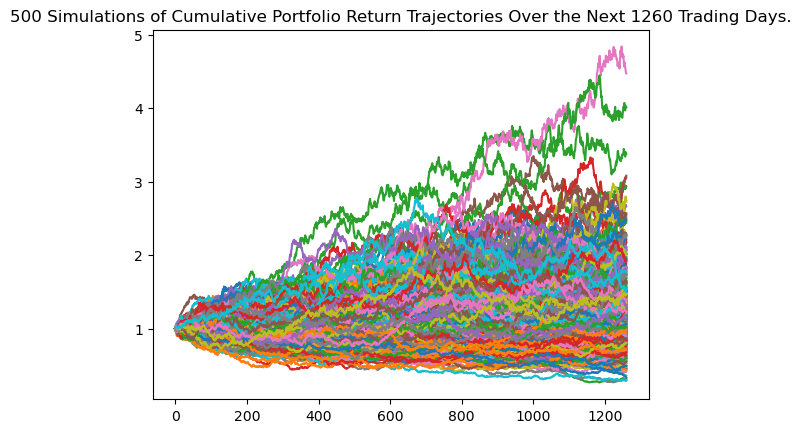

In [109]:
# Plot simulation outcomes
five_year_line_plot_con_disc = MC_5_year_con_disc.plot_simulation()

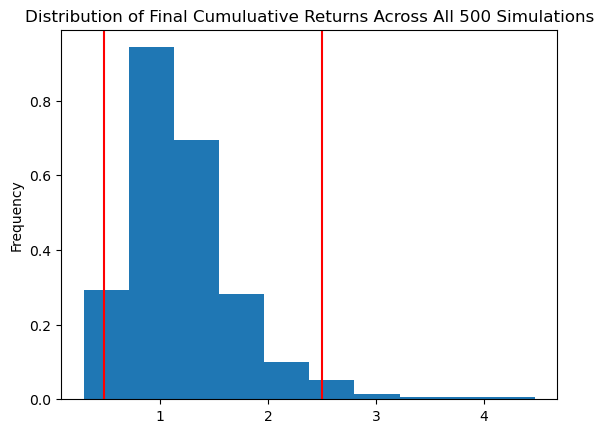

In [110]:
# Plot probability distribution and confidence intervals
five_year_dist_plot_con_disc = MC_5_year_con_disc.plot_distribution()

In [111]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_disc = MC_5_year_con_disc.summarize_cumulative_return()

# Print summary statistics
print(five_year_summary_con_disc)

count           500.000000
mean              1.205825
std               0.522524
min               0.294236
25%               0.862964
50%               1.096734
75%               1.456832
max               4.472814
95% CI Lower      0.484203
95% CI Upper      2.500816
Name: 1260, dtype: float64


In [112]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five_con_disc = round(five_year_summary_con_disc.iloc[8]*initial_investment,2)
ci_upper_five_con_disc = round(five_year_summary_con_disc.iloc[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_con_disc} and ${ci_upper_five_con_disc}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $9684.06 and $50016.32


# Part VI: Plots/Visualizations

Plots Needed:
1. Historical analysis(All Line Charts): daily returns, historical values, and cumulative returns
2. Risk Analysis: Boxplot
3. Monte Carlo: box plot of summary stats
4. Pie/Donut Charts represent each portfolios weighted distribution?

*Pie/donut chart showing each portfolio's distribution

<Axes: title={'center': 'Cumulative Returns of all Portfolios'}, xlabel='timestamp'>

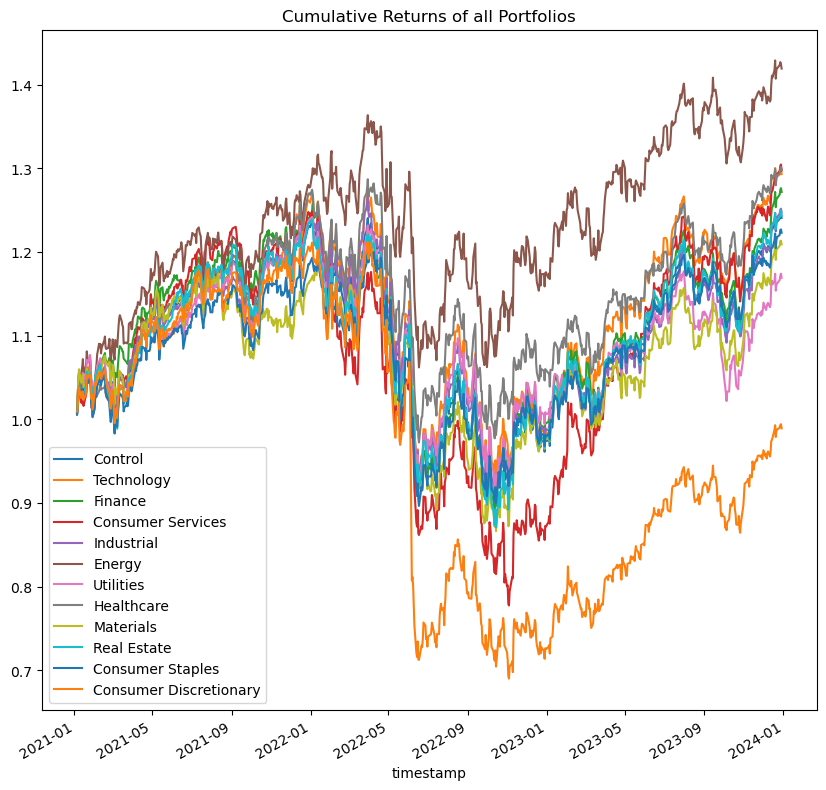

In [120]:
# Example starter plot for cumulative returns
all_cumulative_returns_df.plot(figsize=(10,10), title="Cumulative Returns of all Portfolios")

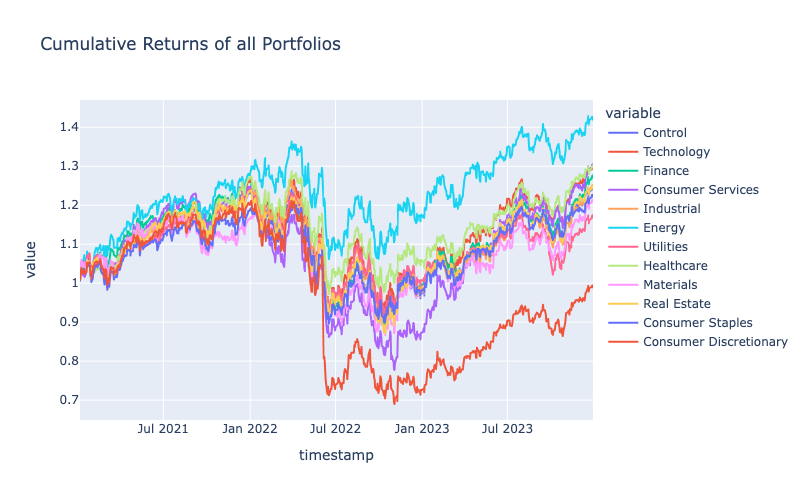

In [126]:
hist_cumulative_returns_fig = px.line(all_cumulative_returns_df, width=800, height=500, title="Cumulative Returns of all Portfolios")
hist_cumulative_returns_fig.show()

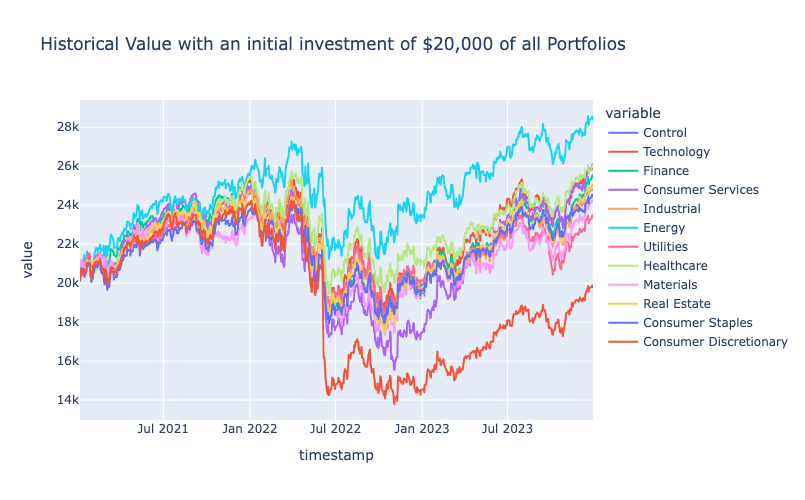

In [127]:
historical_values_fig = px.line(all_historical_values_df, width=800, height=500, title="Historical Value with an initial investment of $20,000 of all Portfolios")
historical_values_fig.show()

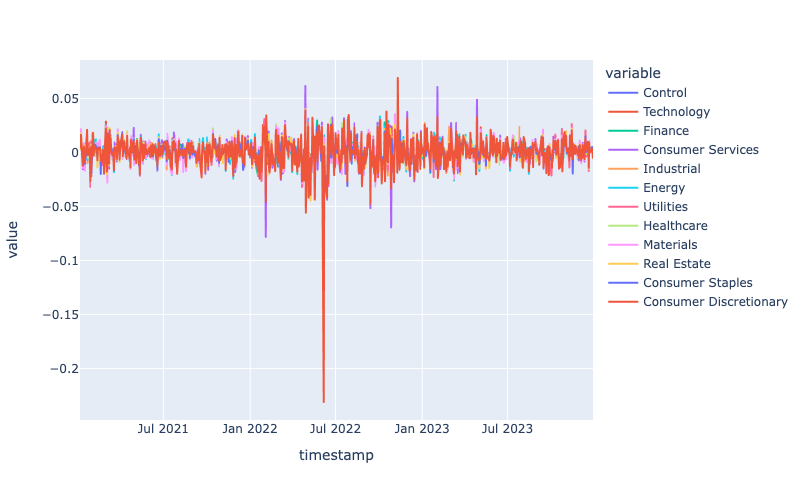

In [128]:
hist_daily_returns_fig = px.line(all_returns_df, width=800, height=500, title="Daily Returns of all Portfolios")
fig.show()

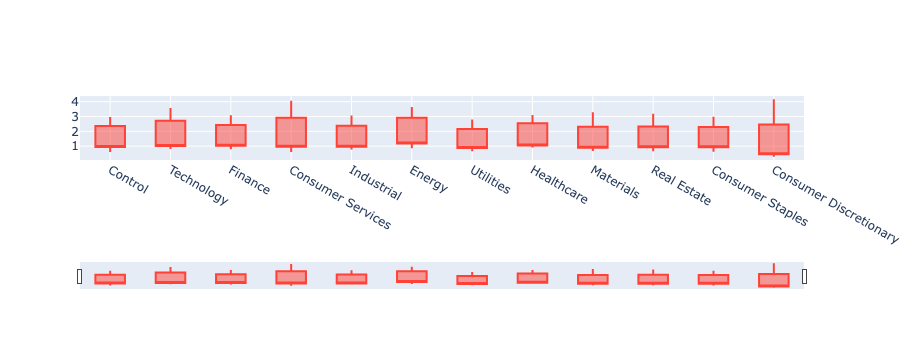

In [133]:
# Plotting the upper and lower CI 95% of all MC simulation(min/max = high/low; open/close = CIupper/CIlower
min_data = [0.612243, 0.805576, 0.786399, 0.604798, 0.769029, 0.862505, 0.649108, 0.909431, 0.677289, 0.647386, 0.628008, 0.280719]
max_data = [2.967900, 3.577134, 3.090839, 4.066498, 3.077694, 3.639074, 2.797470, 3.107733, 3.281936, 3.183344, 2.978899, 4.169834]
ci_upper = [2.363665, 2.707885, 2.420722, 2.917650, 2.374532, 2.917394, 2.165186, 2.553763, 2.301589, 2.331461, 2.292041, 2.457851]
ci_lower = [0.949598, 1.015959, 1.030039, 0.964470, 0.958643, 1.173393, 0.876502, 1.047440, 0.892707, 0.924784, 0.923972, 0.450766]
portfolios = ['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary']

fig = go.Figure(data=[go.Candlestick(x=portfolios,
                       open=ci_upper, high=max_data,
                       low=min_data, close=ci_lower)])

fig.show()

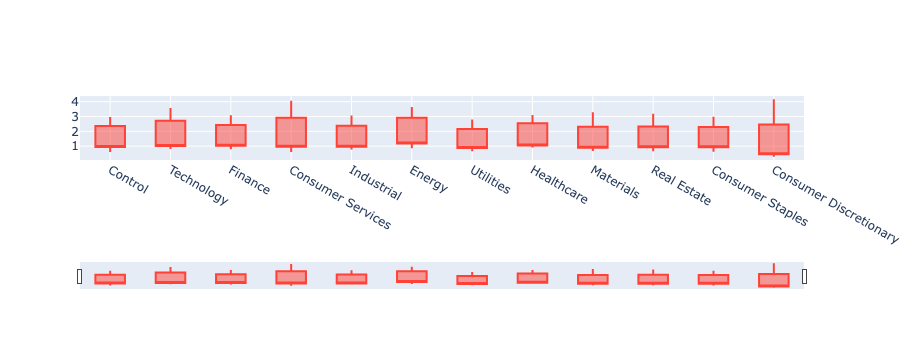

In [134]:
# Plotting the upper and lower CI 95% of all MC simulation(min/max = high/low; open/close = CIupper/CIlower
min_data = [0.612243, 0.805576, 0.786399, 0.604798, 0.769029, 0.862505, 0.649108, 0.909431, 0.677289, 0.647386, 0.628008, 0.280719]
max_data = [2.967900, 3.577134, 3.090839, 4.066498, 3.077694, 3.639074, 2.797470, 3.107733, 3.281936, 3.183344, 2.978899, 4.169834]
ci_upper = [2.363665, 2.707885, 2.420722, 2.917650, 2.374532, 2.917394, 2.165186, 2.553763, 2.301589, 2.331461, 2.292041, 2.457851]
ci_lower = [0.949598, 1.015959, 1.030039, 0.964470, 0.958643, 1.173393, 0.876502, 1.047440, 0.892707, 0.924784, 0.923972, 0.450766]
portfolios = ['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary']

fig = go.Figure(data=[go.Candlestick(x=portfolios,
                       open=ci_upper, high=max_data,
                       low=min_data, close=ci_lower)])

fig.show()